# Phase 4 Project
## US Energy Generation

Student name: Maria Kuzmin
<br>Student pace: Flex
<br>Scheduled project review date/time: Tuesday, March 21st 10AM
<br>Instructor name: Morgan Jones

## Time Series Model:

### Business Problem:

Electrical Energy is constantly in more demand. 
<br>With technology advancing and broadening applications in different fields there are always more industries heavily depending on significant amounts of electricity.
<br>A few examples of these industries are data centers, hospitals & healthcare facilities, warehouses & distribution centers, and the list goes on (for more details on this you can read [this article](https://www.globalpwr.com/top-ten-industries-requiring-megawatts-of-generator-power/)). 
<br>Whether you want to invest in the energy sector and are looking into what type of source for power you should focus on, or if you are looking to start a massive Cloud service, and wondering where is the most efficient location to have your data servers built and run, or you want to invest in a hospital or a warehouse, this project aims at helping you understand what energy source and state within the United States, is best for you. 
<br>We are going to study the different sources of energy and how their production has been growing or decreasing in the past 20 years. Ultimately we will try to identify what would be the most reliable source of energy to focus on. 
<br>We will then try to predict the production via that source for the next 3 years. <br>Consequently we will look at what are the states that have been the greatest productors, and what is the seasonal pattern in those states.

### Summary:
    
We studied the production of electrical energy in the United States, from 2001 until May 2022.
<br>The data has information on the energy produced, with one record per month, divided by sources and by state.
<br>The dataset consists of 496774 rows × 6 columns. This seemed like an appropriate amount of data, giving us a chance to dig deeper into certain aspects like source or state, and had information that was very recent, going all the way up to 2022 making our future predictions relevant and interesting.
<br>We decided to focus on the production of electricity via natural gas, as that showed a promising positive trend.

Data Preparation: we organised the data by date, studied it in terms of the production in all of the US, and also separated it by state.
The libraries used:
- Pandas was used for parsing the data to a date format and working with DataFrames and Series. It seemed a good choice since it allowed us to read the file, create a DataFrame and parse the date, all in one line of code.
- NumPy for basic math and statistic operations.
- SciPy to run an analysis on our data samples, to make sure there were no particular anomalies in the data.
- Sklearn in order to do a time series split, which we used for a cross validation.

For modelling we used statsmodels.
<br>We decided to create a few ARMA models and later run a gridsearch to find the best parameters.
<br>Consequently we used SARIMAX to add the seasonal aspect to our models, and ran two grid searches to find the best performing model.
<br>To compare the models and pick the best ones we used a cross-validation on a split we made from the train set. The best model we picked had an AIC of 173.5.
<br>With this model we made predictions on the test set, for a span of 51 months, and obtained predictions with a RMSE of 10.9 TWh.
<br>We forecasted our data in the future for 3 years, and obtained results with a MSE between 5-9 TWh, finding a growth of up to 16.7%.
<br>We also studied the production of natural nas by state and studied the seasonality of the time series.

## How are we going to get there:

Here is a roadmap of the steps that we are going to take:

* [The Data:](#Data)
    * Data Preparation
    * Study of Energy Source
    * Natural gas, solar and wind
    * Checking for normality
* [EDA of Natural gas:](#EDA)
    * Split Train Validation and Test Set
    * Subtracting Rolling Mean
    * Series Decomposition
    * Studying Autocorrelation: ACF PACF
* [Modeling:](#Modeling)
    * Baseline Model: Naive
    * ARMA Models
    * Grid Search for ARIMA models
        * First Search
        * Best model from Grid Search
        * Cross Validation
        * Second Search
        * Best model from second search
        * Cross Validation
    * SARIMAX
        * First Grid Search SARIMAX
        * Best model after first search
        * Cross Validation
        * Second Grid Search SARIMAX
        * Best model after second search
        * Cross Validation
* [Predicting on the test](#Pred)
* [Forecasting in the future](#Fore)
* [Study of Seasonality and States](#SSS)
* [Results](#Resu)
* [Limitations](#Lim)
* [Recommendations](#Rec)

### Imports:

Let us start by loading the datasets and see what type of data we are dealing with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from colorama import Fore
from colorama import Style

plt.style.use('ggplot')

# The Data <a id='Data'></a>

This CSV (organised_Gen.csv) is adapted from https://www.eia.gov/electricity/, where the main information related to energy generation in the United States is located. This dataset has the following columns:

<br>YEAR
<br>MONTH
<br>STATE
<br>TYPE OF PRODUCER
<br>ENERGY SOURCE
<br>GENERATION (Megawatt-hours)
<br>Unnamed:0 (ID)

<br>Source: U.S. Energy Information Administration (Sep 2021).
<br>The dataset consists of 496774 rows that span the timeframe from January 1st 2001 until May 1st 2022, with one record per month.
<br>The data is divided by energy source, type of producer and state.
<br>The column we will focus on is the GENERATION one, which we will study in its evolution over time and which will also be the target for our study, since we want to predict the values of energy generated in the future.

Let's load US energy generation.
Since this is a time series and we are very interested in the information about time we will directly load the dataset with that information, creating a new column 'date' that contains both the month and the year of the record.

In [2]:
df = pd.read_csv('organised_Gen.csv', parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

,date,Unnamed: 0,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,2001-01-01,0,AK,Total Electric Power Industry,Coal,46903.0
1,2001-01-01,1,AK,Total Electric Power Industry,Petroleum,71085.0
2,2001-01-01,2,AK,Total Electric Power Industry,Natural Gas,367521.0
3,2001-01-01,3,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
4,2001-01-01,4,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...,...,...
496769,2022-05-01,10581,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
496770,2022-05-01,10582,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
496771,2022-05-01,10583,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0
496772,2022-05-01,10584,WY,"Electric Generators, Electric Utilities",Petroleum,1812.0


## Data Preparation:

As we can see 'Unnamed:0' is a form of ID but we don't really need that, since the data is already organized chronologically, so we can remove that column, and we will also set the date as the index.

In [3]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903.0
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085.0
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521.0
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
2001-01-01,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...
2022-05-01,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0


#### Checking for null values:
We are going to check to see if there are missing values in the time series.
If we find them, we can use several tools like back filling, forward filling or interpolate to fill in the missing data.

In [4]:
df.isna().sum()

STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

We are lucky to have a dataset that does not have any missing data!
We can move on to checking some statistics on the data, on the one numeric column, and then we will explore the content of the categorical columns

In [5]:
df.describe()

,GENERATION (Megawatthours)
count,4.967740e+05
mean,1.393384e+06
std,1.078685e+07
min,-9.978550e+05
25%,1.643000e+03
50%,2.330103e+04
75%,2.792042e+05
max,4.217967e+08


We can deduce from this information that there are some very heavy outliers in this distribution. The first thing that tells us so is the standard deviation, which has a value of 10^7.
We can also note that both the 25% percentile and the 75% percentile are far from the min and max.
This is probably due to a lot of values in our distribution that are zero or close to it, and some very heavy outliers past the 75 percentile, since the difference with the max value is over three orders of magnitude.
We should also note the min value which is negative, this is due to the category of pumped storage since its behaviour is similar to a battery, requiring energy for loading and to be used afterward.
We can plot an histogram of the distribution to see also visually how the data is distributed.

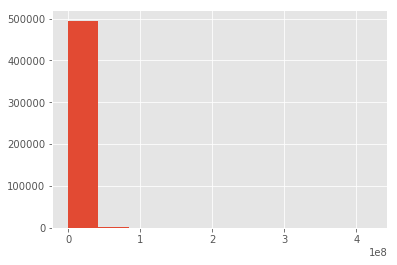

In [6]:
df['GENERATION (Megawatthours)'].hist();

This graph confirms what we observed from the `describe()` table, there are many values around zero and also many outliers towards the maximum.
<br>This is still a very generic sample since it includes all the different sources from all the different states (and also their totals) for all the time span from 2001 to 2022.
<br>We will do some filtering and select only some of this information and we will find more specific samples to work on (only totals , only certain sources, only certain states...)

Let us take a look at the other columns.

In [7]:
df['TYPE OF PRODUCER'].value_counts()

Total Electric Power Industry                       134452
Electric Generators, Electric Utilities              93792
Electric Generators, Independent Power Producers     89439
Combined Heat and Power, Industrial Power            77804
Combined Heat and Power, Commercial Power            53928
Combined Heat and Power, Electric Power              47359
Name: TYPE OF PRODUCER, dtype: int64

The 'Total Electric Power Industry' is the sum of all the other ones, so we will focus only that type of producer. A further study could be done analyzing each one of them, but that is beyond the scope of our analysis.

In [8]:
total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']

Looking at the different states:

In [9]:
df['STATE'].value_counts().head()

US-TOTAL    18322
CA          15477
MI          14208
PA          13222
NY          12882
Name: STATE, dtype: int64

For now we will also focus on 'US-TOTAL' which is the sum of the production in all the states. We will study certain states in depth later on in the project but for now we are focusing on the trends in the overall United States.

In [10]:
US_total=total.loc[total['STATE']=='US-TOTAL']

In [11]:
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177287111.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18111843.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42388663.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,718442.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68707077.0
...,...,...,...,...
2022-05-01,US-TOTAL,Total Electric Power Industry,Petroleum,1524488.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15151118.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1440366.0


#### Changing Scale
GIven the high values for the column 'Generation (Megawatthours)' once we take the totals, we will convert the units to Terawatts per hour, where TWh=MWh*10^6.

In [12]:
US_total["Generation (TWh)"]=US_total["GENERATION (Megawatthours)"]/1000000
US_total.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
date,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177.287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18.111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42.388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,0.718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68.707077
...,...,...,...,...
2022-05-01,US-TOTAL,Total Electric Power Industry,Petroleum,1.524488
2022-05-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15.151118
2022-05-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1.440366


#### Energy Sources

In [13]:
US_total['ENERGY SOURCE'].value_counts()

Other Biomass                     257
Hydroelectric Conventional        257
Total                             257
Geothermal                        257
Wind                              257
Wood and Wood Derived Fuels       257
Pumped Storage                    257
Petroleum                         257
Nuclear                           257
Coal                              257
Natural Gas                       257
Other                             257
Solar Thermal and Photovoltaic    257
Other Gases                       257
Name: ENERGY SOURCE, dtype: int64

Here we get to the interesting part: we want to study the trend of the different energy sources, overall in the United States, over time.
    To do that we need to do a groupby and filter out the 'Total' value that sums up all of the different energy sources.

In [14]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [15]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

In [16]:
US_source

,date,ENERGY SOURCE,Generation (TWh)
0,2001-01-01,Coal,177.287111
1,2001-01-01,Geothermal,1.229325
2,2001-01-01,Hydroelectric Conventional,18.852048
3,2001-01-01,Natural Gas,42.388663
4,2001-01-01,Nuclear,68.707077
...,...,...,...
3592,2022-05-01,Petroleum,1.524488
3593,2022-05-01,Pumped Storage,-0.466746
3594,2022-05-01,Solar Thermal and Photovoltaic,15.151118
3596,2022-05-01,Wind,41.891907


Let's take a look:

### Previewing the data by energy source

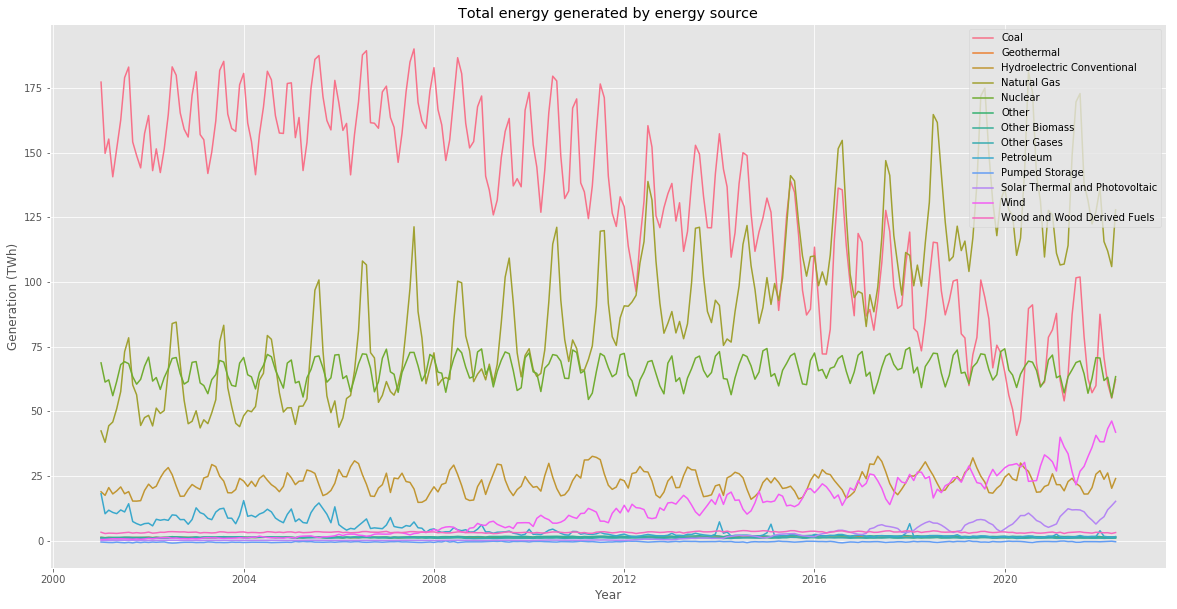

In [17]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source, x=US_source['date'] \
             ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show();

This graphs is a little crowded since it contains all the different energy sources.
<br>Let us divide them up to be able to better see form the graphs their trends.

In [18]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [19]:
US_top3

,date,ENERGY SOURCE,Generation (TWh)
0,2001-01-01,Coal,177.287111
3,2001-01-01,Natural Gas,42.388663
4,2001-01-01,Nuclear,68.707077
14,2001-02-01,Coal,149.735484
17,2001-02-01,Natural Gas,37.966927
...,...,...,...
3573,2022-04-01,Natural Gas,105.934050
3574,2022-04-01,Nuclear,55.289540
3584,2022-05-01,Coal,62.288238
3587,2022-05-01,Natural Gas,127.926186


### Top 3: Coal, Natural Gas and  Nuclear

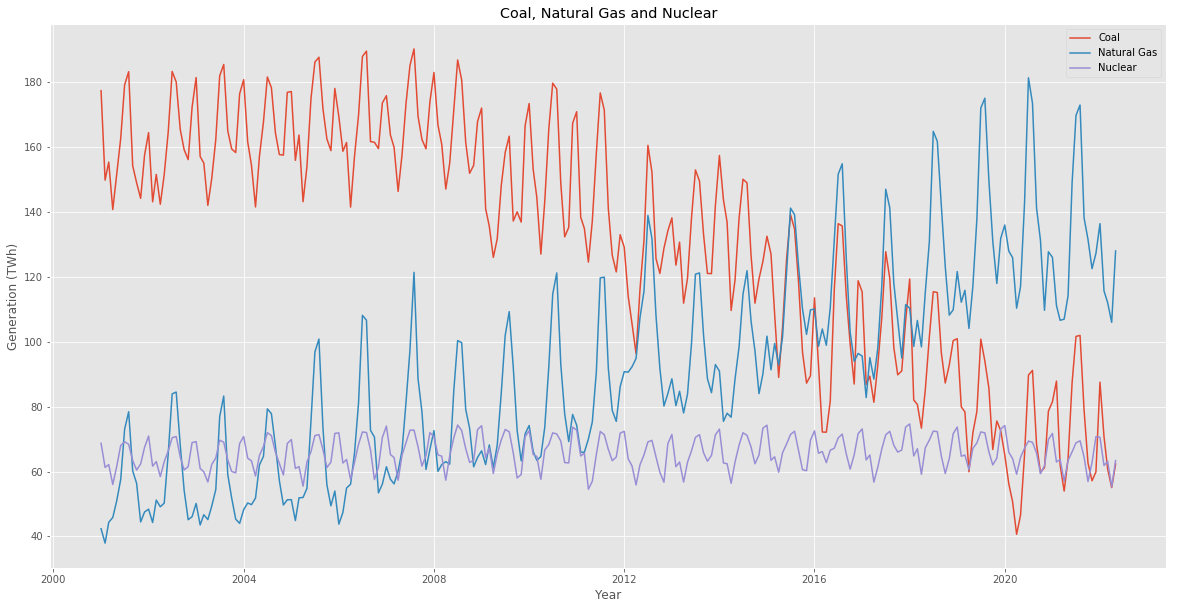

In [20]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['date'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best');

We can see here how the production of energy by coal was the most used one up until 2012. There started to be a decreasing trend from 2008 until recent years, and we can see the drop in 2020, probably due to the pandemic that stopped workers from being able to extract coal and therefore the production dropped.
<br>Natural gas has an interesting steady growing trend that brought it to be at the top of the production sources from around 2016. We will study this time series in more detail during this project.
<br>The production of electrical power via nuclear sources has been more or less stable (with some seasonality) in the past 20 years, this is probably due to the risks that this type of source carries, which prevented it from growing.

### Next 4: Wind, Hydroelectric, Solar and Oil

In [21]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

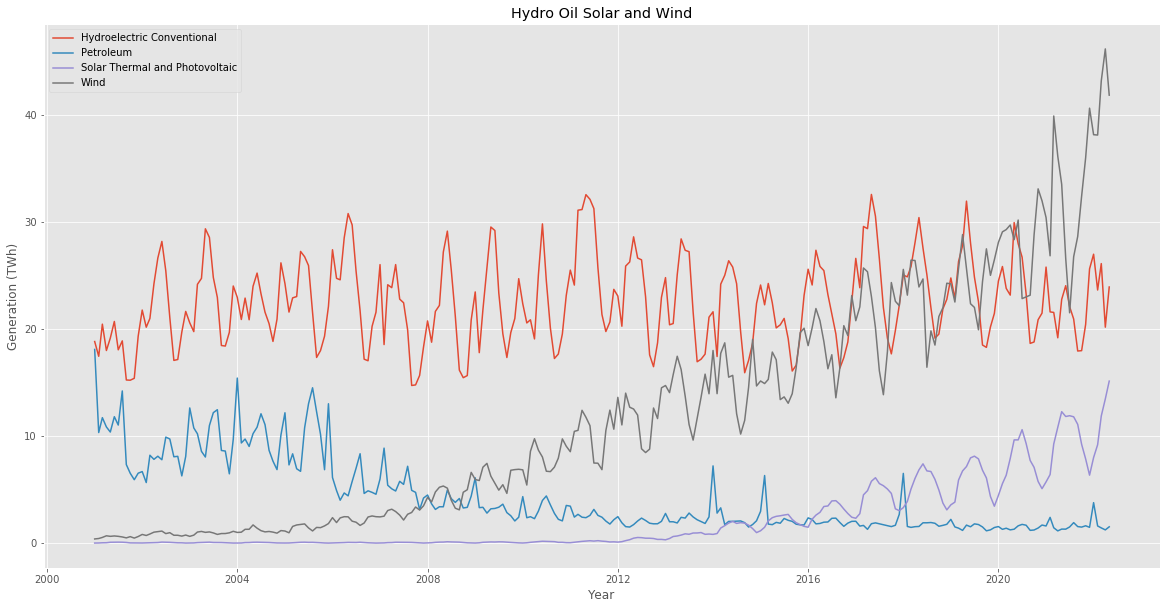

In [22]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['date'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Hydro Oil Solar and Wind")
plt.xlabel("Year")
plt.legend(loc='best');

The two most interesting trends in our opinion are solar and wind. We can see how they have both been growing, with a trend that seems to be even exponential.
The production of energy via wind started to grow around 2004, but it has also an increasing variance over time. We can imagine that this is related to the atmospheric factors that influence so heavily the production with this source.
<br>For solar and photovoltaic power, this started to grow more steadily around 2014, with also some seasonality and variance, also probably related to the weather. For a long time solar technology was not really efficient and had a lot of limitations, but clearly with improvements in its technology it is becoming more popular and productive.
<br>We can see a more or less steady production with hydroelectric, which also shows some serious variance, this makes sense since during winter this technology is not really an option in some states that reach below freezing temperatures.
<br>There is a clear downward trend in the production of electricity via petroleum, especially from 2008, probably due to environmental concerns.

### Bottom of the pack:

In [23]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

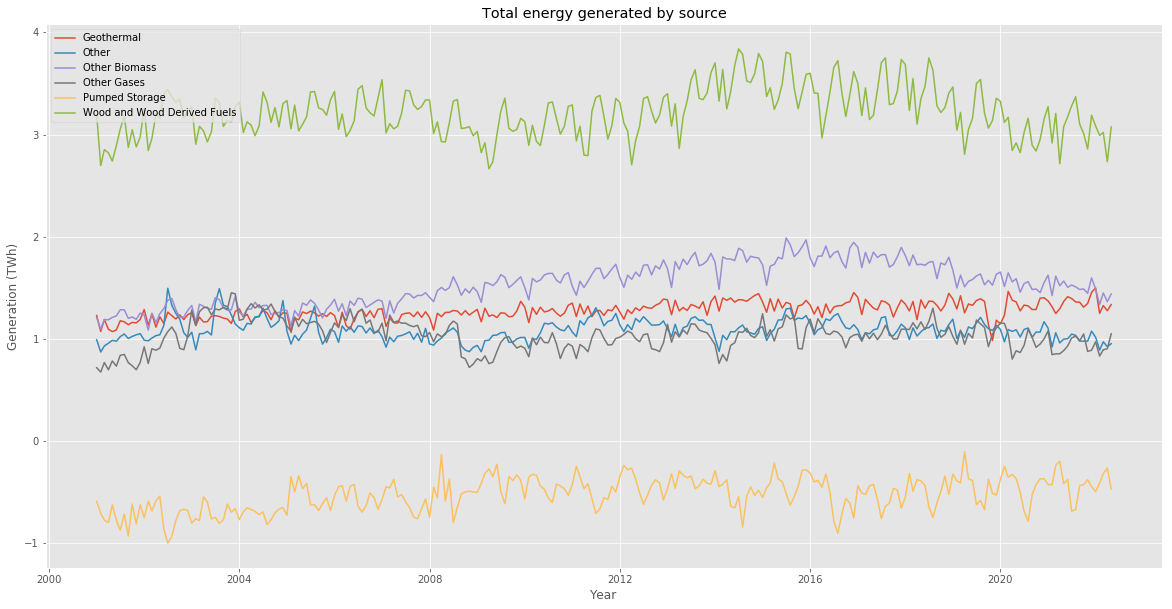

In [24]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['date'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source")
plt.xlabel("Year")
plt.legend(loc='upper left');

Here we can see how the production of energy with wood has seen and increase between 2013 and 2019 but has been decreasing since. This is also probably due to envirormental concerns.
The other sources of energy are all more or less stable, with just an increase for biomass that seems to be decreasing again more recently.
As we already mentioned for pumped storage, this is a source that has negative values by convention because of the way it works, it also pretty stable values over the years.

### The three most growing ones: Natural Gas, Solar and Wind

The sources that have shown to be more interesting, with an upward trend over time are:
 natural gas, wind and solar (which includes thermal and photovoltaic). So let us preview those.

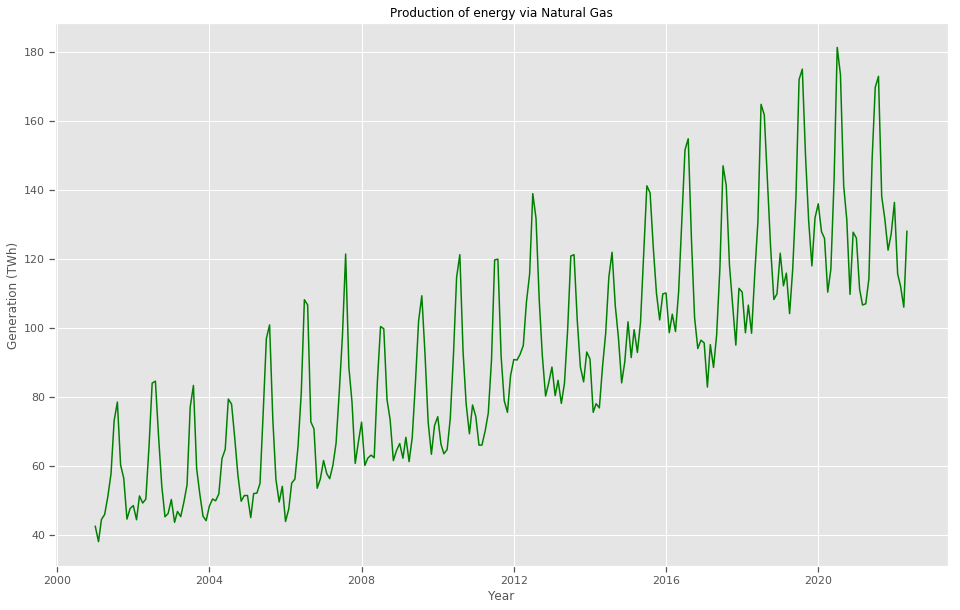

In [25]:
sns.set_context("notebook")
plt.figure(figsize=(16,10))
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green')
plt.title('Production of energy via Natural Gas')
plt.xlabel("Year");

We can see a stable trend of growth for natural gas, since the early 2000.

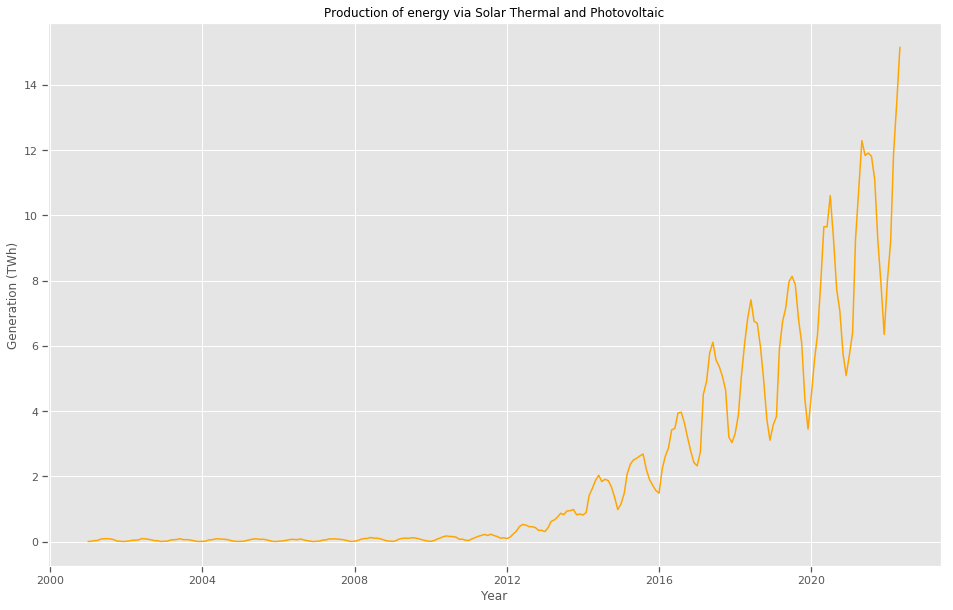

In [26]:
plt.figure(figsize=(16,10))
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange')
plt.title('Production of energy via Solar Thermal and Photovoltaic')
plt.xlabel("Year");

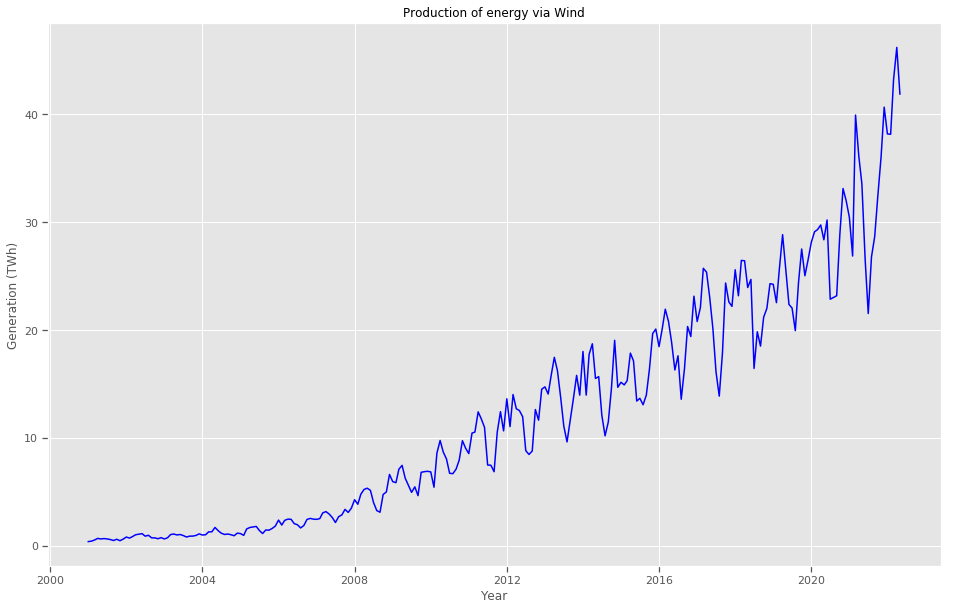

In [27]:
plt.figure(figsize=(16,10))
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)'], color='blue')
plt.title('Production of energy via Wind')
plt.xlabel("Year");

Solar and wind both show and exponential growth in their trend, for solar starting around 2012 and for wind around 2006.

## Checking for Normality, skewness and kurtosis

Let us check the distribution of our data for these 3 sources. We don't necessarily need normality in their distribution but it is good to get a sense of the data that we are working with and make sure there are no anomalies.

### Natural Gas:

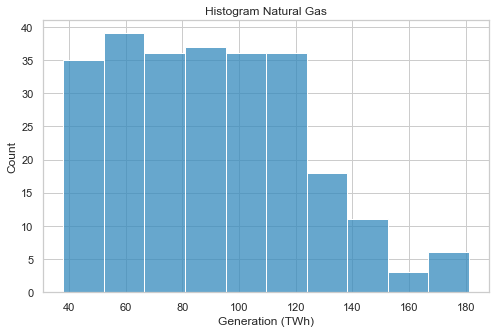

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.histplot(US_nat['Generation (TWh)'])
plt.title('Histogram Natural Gas');

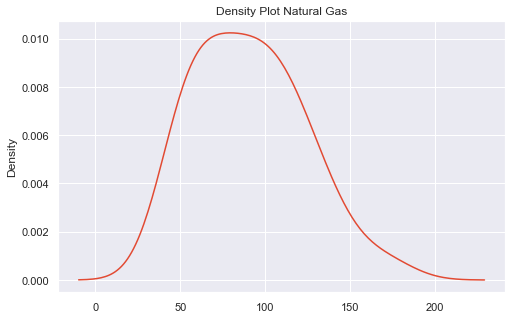

In [29]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Density Plot Natural Gas')
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);

There is clearly a skew in the data because the lowest value of production we have, around 2001, is around 40 TWh, it does not start at zero. Let us use our tools from SciPy to get actual values for normality, skewness and kurtosis.

In [30]:
k2, p = stats.normaltest(US_nat['Generation (TWh)'])
kur = kurtosis(US_nat['Generation (TWh)'], fisher=True)
sk=skew(US_nat['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:0.003959050613625347
The value for kurtosis for this sample is: -0.35228324109119846
The value of skewness for this sample is:0.4830844892501781


The null hypothesis for the normal test is that the sample comes from a normal distribution.
<br>In our case with a standard alpha of 0.05 we can say that we can reject the null hypothesis and say that our sample is not normally distributed.
<br>With Fisher's definition of kurtosis normal=0 so we are pretty close to normality in terms of kurtosis.
<br>The value of 0.48 for skew indicates that our distribution is moderately skewed, as we could infer from looking at the graphs.

### Solar

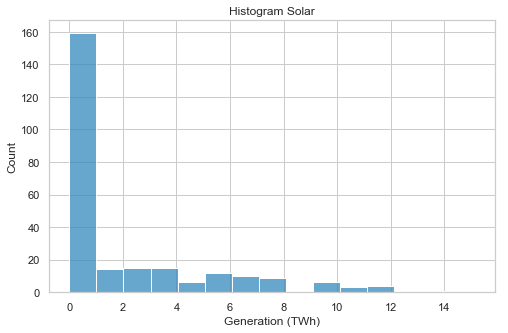

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
plt.title('Histogram Solar')
sns.histplot(US_sol['Generation (TWh)']);

We notice here a lot of values around zero, we expected that from the time series graph, considering the production of energy via solar and photovoltaic wasn't really popular before 2012.

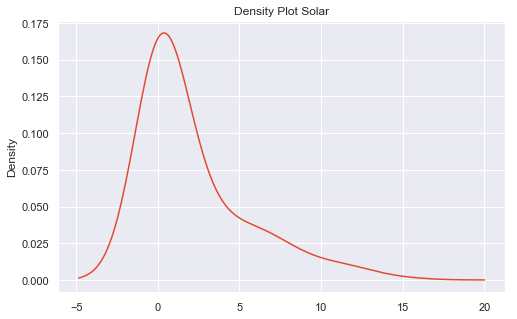

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Density Plot Solar')
sns.kdeplot(np.array(US_sol['Generation (TWh)']), bw=0.5);

In [33]:
k2, p = stats.normaltest(US_sol['Generation (TWh)'])
kur = kurtosis(US_sol['Generation (TWh)'], fisher=True)
sk=skew(US_sol['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:6.333758801915125e-19
The value for kurtosis for this sample is: 2.135719804718372
The value of skewness for this sample is:1.6823253826109177


In the case of solar energy also we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis higher than 2, which also takes our sample outside of normality.
<br>The value of 1.68 for skew indicates that our distribution is skewed, but still acceptable in the range for normality.

### Wind

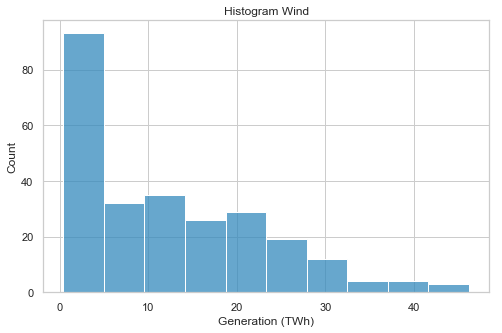

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
plt.title('Histogram Wind')
sns.histplot(US_wind['Generation (TWh)']);

Same consideration as for solar energy, wind was not really used as a source before 2004.

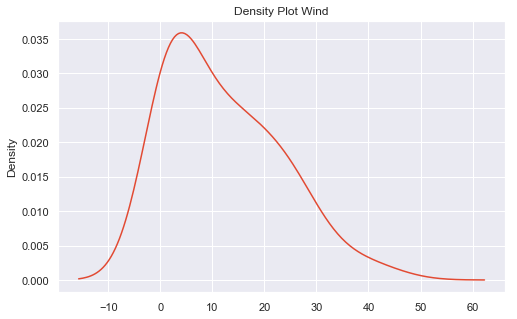

In [35]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Density Plot Wind')
sns.kdeplot(np.array(US_wind['Generation (TWh)']), bw=0.5);

In [36]:
k2, p = stats.normaltest(US_wind['Generation (TWh)'])
kur = kurtosis(US_wind['Generation (TWh)'], fisher=True)
sk=skew(US_wind['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:1.2775838040979476e-05
The value for kurtosis for this sample is: -0.14672678485081514
The value of skewness for this sample is:0.7875242470552442


For our sample of energy generated by wind we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis of -0.14 which means the curve is too flat to be normal, but still pretty close to the zero of normality.
<br>The value of 0.78 for skew indicates that our distribution is skewed, but not very far from the range for normality.

The ultimately deciding factor is the p value so we have to accept that all three of our samples are not normally distributed. <br>Normality is not a requirement in time series, but this study let us understand more the characteristic of the samples we working with.

### Focusing on one source:

Ideally we would continue our whole analysis on all three sources, but for reasons of time we need to focus on only one.
<br>The exponential trend of solar and wind are very interesting, but they both carry risk due to their vulnerability toward factors out of our control: principally weather.
<br>Cold and frigid temperatures, rain, clouds, ice, and snow can all heavily influence the performance of these sources therefore we consider them less dependable.
<br>This is why we decided to continue our analysis focusing only on natural gas, whose production does not depend so heavily on uncontrollable factors.

# EDA of Natural Gas<a id='EDA'></a>

## Split Train Validation and Test set

Now that we have decided what source we are going to work on, we are going to perform a train-validation-test split so that the models we are going to create, based only on the information we have from the train, do not suffer from data-leaking.
<br>We will do cross validation on our top models (that we will idenfity with grid searches), to be able to compare their performance and choose one best model.
<br>We will utimately test our best model on the test set, that in this way will represent data that was not seen by the model.
<br>Lastly we will use our model to forecast for the next 3 years.

Turning the column into a series:

In [37]:
nat=US_nat['Generation (TWh)']

We will do an 80-20 split between the train and the test

In [38]:
# Definig the 80% cutoff for the split train - test
cutoff = round(nat.shape[0]*0.8)
cutoff

206

Defining the two sets, train and test based on the cutoff.

In [39]:
train = nat[:(cutoff+1)] #the +1 is added to avoid gaps in the series
test=nat[cutoff:]

In [40]:
test.index[0]

Timestamp('2018-03-01 00:00:00')

In [41]:
test.index[-1]

Timestamp('2022-05-01 00:00:00')

From here we can see that having performed an 80/20 split for train and test we have the year from January 2018 on as part of the test.

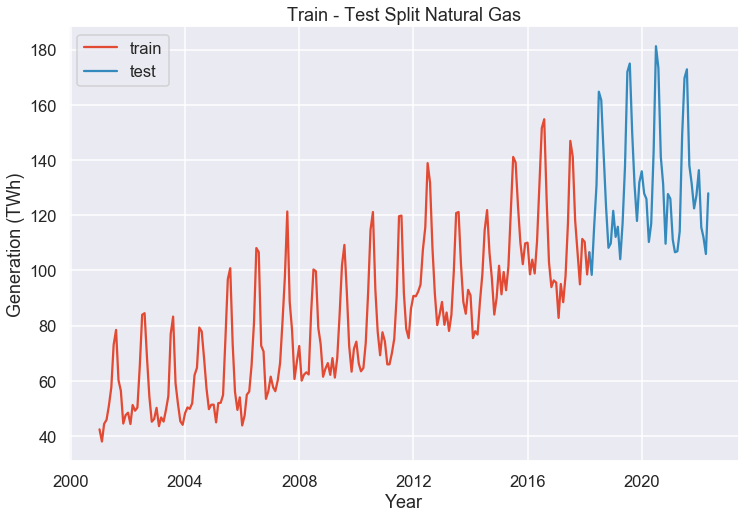

In [42]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train - Test Split Natural Gas');
plt.legend()
plt.xlabel("Year")
plt.ylabel("Generation (TWh)");

In [43]:
train

date
2001-01-01     42.388663
2001-02-01     37.966927
2001-03-01     44.364414
2001-04-01     45.842746
2001-05-01     50.934205
                 ...    
2017-11-01     94.928341
2017-12-01    111.397792
2018-01-01    110.292909
2018-02-01     98.511852
2018-03-01    106.523780
Name: Generation (TWh), Length: 207, dtype: float64

In [44]:
test

date
2018-03-01    106.523780
2018-04-01     98.371080
2018-05-01    115.283982
2018-06-01    130.826400
2018-07-01    164.749060
2018-08-01    161.676241
2018-09-01    141.785528
2018-10-01    123.142239
2018-11-01    108.167635
2018-12-01    109.801976
2019-01-01    121.581777
2019-02-01    112.135473
2019-03-01    115.806072
2019-04-01    104.053161
2019-05-01    117.052615
2019-06-01    137.827808
2019-07-01    171.941961
2019-08-01    174.955372
2019-09-01    149.687661
2019-10-01    130.940660
2019-11-01    117.903947
2019-12-01    131.830286
2020-01-01    135.905175
2020-02-01    127.861217
2020-03-01    125.895408
2020-04-01    110.291535
2020-05-01    116.933505
2020-06-01    142.822497
2020-07-01    181.248097
2020-08-01    173.379404
2020-09-01    141.155144
2020-10-01    131.232950
2020-11-01    109.650802
2020-12-01    127.674265
2021-01-01    125.959747
2021-02-01    111.110664
2021-03-01    106.565144
2021-04-01    106.920249
2021-05-01    114.131496
2021-06-01    148.84

### Validation Set

Instead of taking only one validation set as part of the test set, we chose to use the `TimeSeriesSpit()` function to create splits of train and validation, that can be used for a cross validation.
<br>We can see from the indeces below that the default number of splits is 5, and that the validation set always comes right after the train set, but the train set is increasing in size with every split.
<br>The size of the validation set remains the same.
<br>We will use this later to do cross validation on our models.

In [45]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] [ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104

Now we can start to study our series to see what characteristic it has and how to best build a model for it.

## Stationarity

We know that in order to model on our series we need for it to be stationary.
<br>From what we could observe so far our series has both a trend and a seasonal component that don't make it stationary.
<br>We can verify this by running the Dickey-Fuller test on it (this is usually used on the residulas but here is just for informative purposes).

In [46]:
dftest = adfuller(train)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -0.485707
p-value                          0.894776
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


The Null Hypothesis is that the series is stationary, but the p values is clearly > 0.05, the series is not stationary as we could expect.

### Subtracting Rolling Mean

Next we are going to try to make the series stationary by subtracting the rolling mean, which tells us of the dependence of the series values on the previous values in the past.

In [47]:
roll_mean = train.rolling(window=12, center=False).mean()
roll_std = train.rolling(window=12, center=False).std()

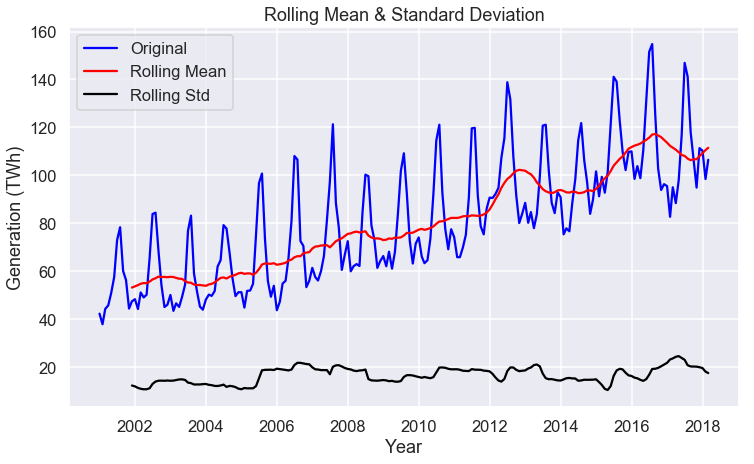

In [48]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)");

<br>We can see how most of the noise was removed by subtracting the rolling mean (since we subtracted the dependence of the time series from the previous 12 months) and we are left with not much more than a trend in our time series.
<br>We can confirm this by subtracting the rolling mean from the series and we can check if the residulas are stationary, again with the Dickey Fuller test:

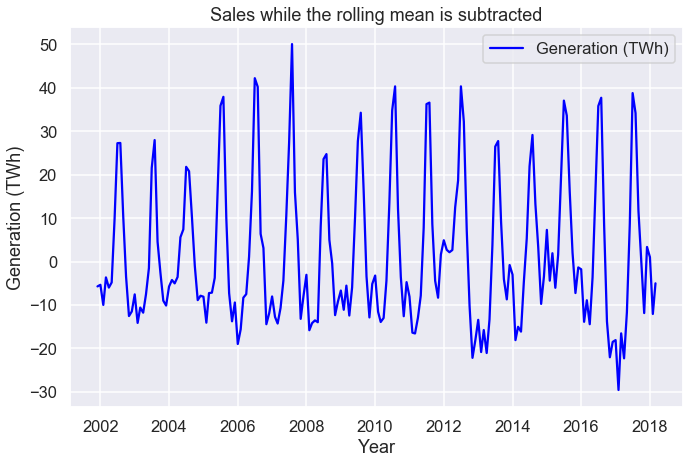

In [49]:
roll_mean_nat = train.rolling(window=12, center=False).mean()
# Subtract the moving average from the original data
data_mrm_nat = train - roll_mean_nat
# Drop the missing values from time series calculated above
data_mrm_nat.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_mrm_nat, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show();

In [50]:
dftest = adfuller(data_mrm_nat)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.536090
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


This time the p value is smaller than 0.005 so this is a sign that the residuals we obtained are indeed a stationary time series.

### Exponential Rolling Mean:
The exponential rolling mean is the same concept as the regular rolling mean, but with the addition that all the previous values are weighted with an exponentially decaying factor, so that the values closer to the present have more weight, are more influential than the values farther in the past.

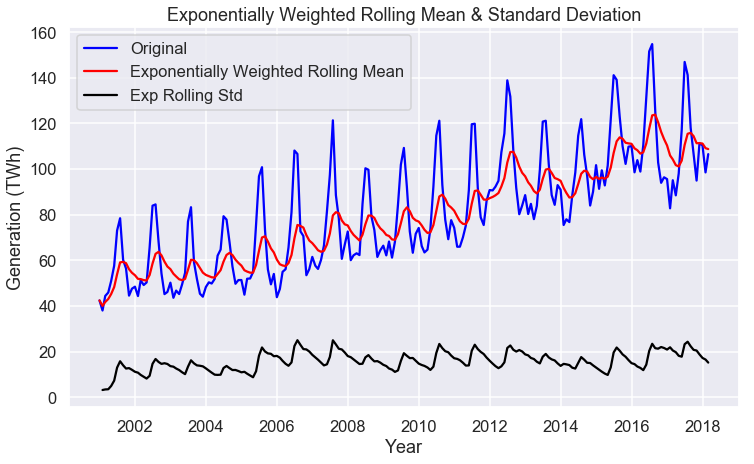

In [51]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = train.ewm(halflife=4).mean()
roll_std = train.ewm(halflife=4).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(train, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)");

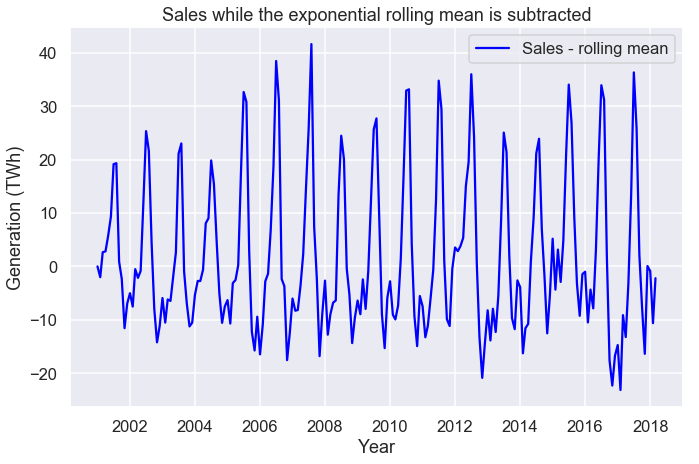

In [52]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = train - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the exponential rolling mean is subtracted')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show(block=False);

In [53]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.880402
p-value                          0.000038
#Lags Used                      14.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


Both tha residuals, subtracting rolling mean and exponential rolling mean, turned out to be stationary. But there is another way to make the series stationary that can give us even more information.

## Series Decomposition

We will proceed to decompose the time series into trend, seasonality and residual using seasonal_decompose( ) from the statsmodels library.

### Decomposing Natural Gas

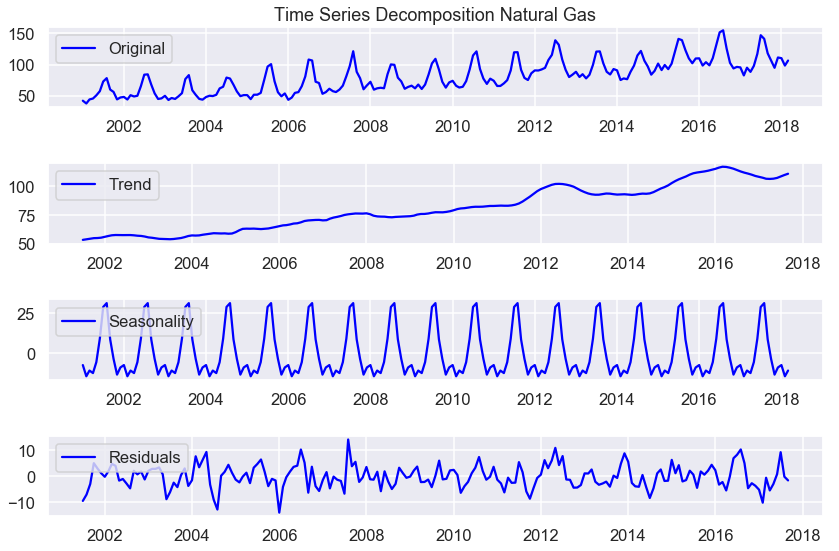

In [54]:
decomposition = seasonal_decompose(train)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(train, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='upper left')

plt.tight_layout();

We can observe from this decomposition an upward trend, which indicates a general overall growth in the production of electrical energy via natural gas.
<br>We can also see a seasonality, with lags of 1 year, with high peaks in the middle of the year (as we can imagine as more energy is required in the summer to power ACs, but we will see this more in detail later).
<br>We can't really see a pattern in the residulas, which is what we want, but we will calculate it with the Dickey-Fuller test to see if the residuals are stationary or not.

In [55]:
residual.dropna(inplace=True)

In [56]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.072536e+00
p-value                        1.141737e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.790000e+02
Critical Value (1%)           -3.467420e+00
Critical Value (5%)           -2.877826e+00
Critical Value (10%)          -2.575452e+00
dtype: float64


The residulas of the series are clearly stationary, since the p value is way below 0.005, and we can confirm it also visually looking at the graph, that is distributed around zero, and looks similar to white noise.

## Studying Autocorrelation

Now to understand more about our time series and what type of dependence it might have on the past, let us take a look at the autocorrelation, we will do that by plotting the Autocorrelation Function and the Partial Autocorrelation Function.

### ACF

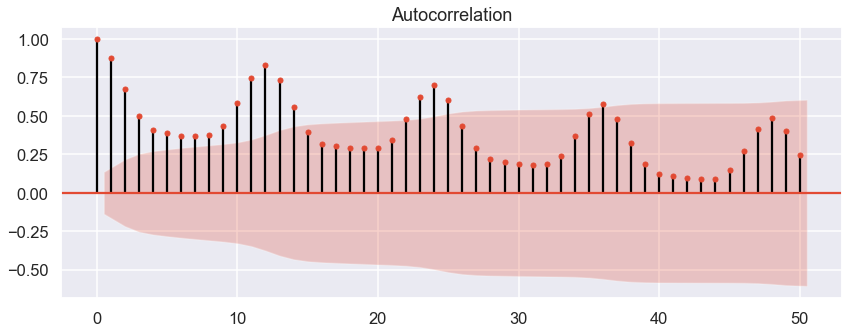

In [57]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train, lags=50);

This first Autocorrelation function shows a strong correlation with a lot of previous time periods.
<br>To get some more clear information about this we will remove the dependence from the previous time period, taking a first difference.

In [58]:
nat_diff = train.diff(periods=1)
nat_diff.dropna(inplace=True)

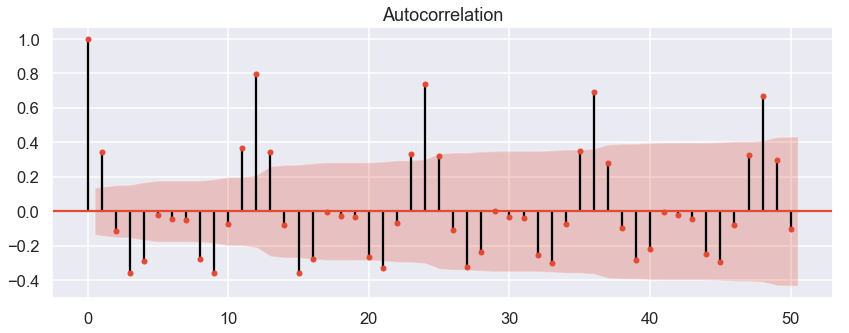

In [59]:
rcParams['figure.figsize'] = 14, 5
plot_acf(nat_diff, lags=50);

This start to make more sense, we start to see a strong dependence of the data on the month before, but also on 12 months before, as well as 11 and 13 months prior.
<br>This makes sense as it is suggesting a yearly cycle that we already started to see in our seasonal decomposition.
<br>This suggests that we should take a first difference, and include a yearly seasonality in our models.

### PACF

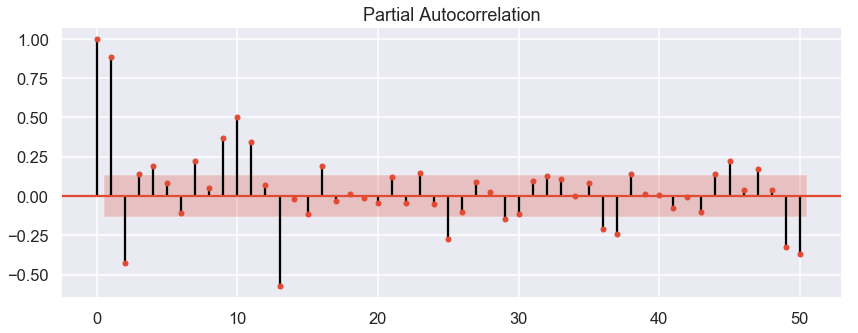

In [60]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(train, lags=50);

### PACF with difference

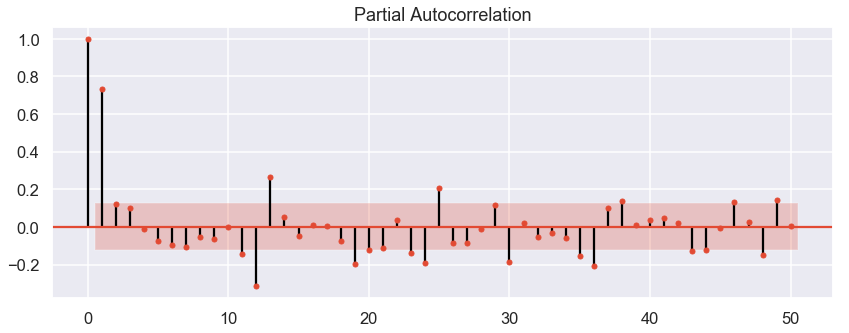

In [61]:
nat_diff12 = nat.diff(periods=12)
nat_diff12.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff12, lags=50);

We can see also with the PACF the seasonality around 12, even thought it's possible that that are some patterns here that we can't fully catch yet.

With the infomation that we gathered so far, we are ready to start building some models.

# Modeling <a id='Modeling'></a>

## Baseline Model:
First we will build a baseline model, specifically the naive model, the simply predicts the data to be equal to the day before, and it is calculated by adding a shift to the original time series.

In [62]:
naive = train.shift(1)
naive

date
2001-01-01           NaN
2001-02-01     42.388663
2001-03-01     37.966927
2001-04-01     44.364414
2001-05-01     45.842746
                 ...    
2017-11-01    106.826275
2017-12-01     94.928341
2018-01-01    111.397792
2018-02-01    110.292909
2018-03-01     98.511852
Name: Generation (TWh), Length: 207, dtype: float64

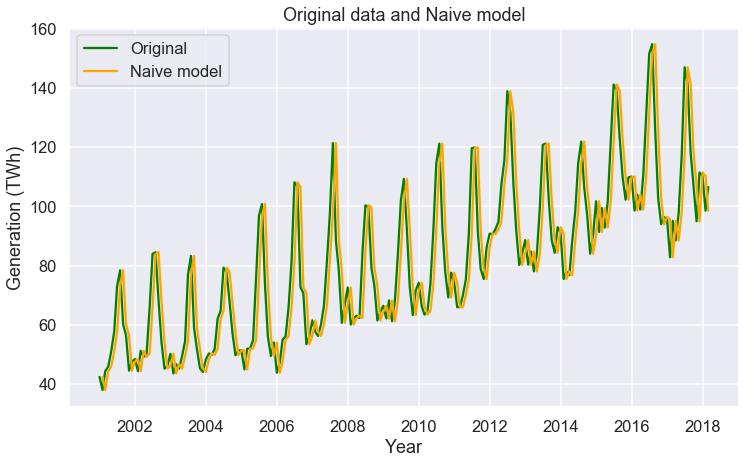

In [63]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='green', label='Original')
plt.plot(naive, color='orange', label='Naive model')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show(block=False)

For a baseline to compare our later models, let us calculate the root mean squared error, RMSE for the naive model.
<br>The Root Mean Squared error calculates the difference between the value predicted by our model and the true value. It ultimately tells us how close our model is to the real data, which is exactly our goal.
<br>But this metric has a shortcoming because it cannot really prevent us from overfitting. We will see more about this later.

In [64]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train[1:], naive.dropna())),2)
print(f'{Fore.BLUE}The RMSE for the naive baseline model is in TWh: {RMSE_naiv}{Style.RESET_ALL}')

The RMSE for the naive baseline model is in TWh: 12.32


## ARMA models

Next we are going to explore some ARMA models, using the ARIMA function from statsmodel.
<br>The ARMA models allow us to input a set or 3 parameters, (p,d,q) which each indicate the number of specific terms in our equation, that will describe our time series.
The term p indicates the number of AR (autoregressive) terms, q is for MA (moving average) terms and d stands for number of differencing factors.
<br>We will monitor the Root Mean Squared error and AIC of the models.
<br>The AIC stands for Akaike information criterion, it is a criterion that penalizes models for having too many terms, in this way preventing overfitting.
For now we will use both these metrics to monitor our progress, and then we will use them separately later in the project.
<br>Just like with RMSE, the lower this number, the better the model.

### AR model

In [65]:
mod_ar = ARIMA(train, order=(1,0,0))

In [66]:
# Fit the model to data
res_ar = mod_ar.fit()

In [67]:
# Print out summary information on the fit
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -808.522
Date:                Mon, 20 Mar 2023   AIC                           1623.044
Time:                        10:18:14   BIC                           1633.042
Sample:                    01-01-2001   HQIC                          1627.087
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.5313      7.535     10.687      0.000      65.762      95.300
ar.L1          0.8870      0.033     26.675      0.000       0.822       0.952
sigma2       143.5185     14.440      9.939      0.000     115.217     171.820
===================================================================================
Ljung-Box (L1) (Q):                  29.19   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               1.35   Skew:                             0.21
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see from the p values none of the terms in the model is superfluous in our prediction.
Next calculating AIC and RMSE and appending them to a list (to compare models later).

In [68]:
aics=[]
aics.append(['armd', res_ar.aic])
res_ar.aic

1623.0442763976707

In [69]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [70]:
rmses=[]
rmses.append(['armd',find_rmse(res_ar)] )
print(find_rmse(res_ar))

12.20852883438684


### Random Walk

Taking only 1 difference, random walk model.

In [71]:
rw = ARIMA(train, order=(0,1,0))

In [72]:
# Fit the model to data
res_rw = rw.fit()

In [73]:
# Print out summary information on the fit
res_rw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -809.685
Date:                Mon, 20 Mar 2023   AIC                           1621.369
Time:                        10:18:14   BIC                           1624.697
Sample:                    01-01-2001   HQIC                          1622.715
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       151.8956     15.111     10.052      0.000     122.279     181.512
===================================================================================
Ljung-Box (L1) (Q):                  24.64   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.00   Prob(JB):                         0.53
Heteroskedasticity (H):               1.38   Skew:                            -0.19
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
aics.append(['rwlk', res_rw.aic])
res_rw.aic

1621.369318497057

In [75]:
rmses.append(['rwlk',find_rmse(res_rw)] )
print(find_rmse(res_rw))

12.642538069503233


The AIC has slightly decreased, but the RMSE has increased, let us see next an autoregressive term with the first difference, that seemed to be a good option from the ACF and PACF graphs.

### AR with First Difference

In [76]:
mod_arfd = ARIMA(train, order=(1,1,0))

In [77]:
# Fit the model to data
res_arfd = mod_arfd.fit()

In [78]:
# Print out summary information on the fit
#res_arfd.summary()

In [79]:
aics.append(['arfd', res_arfd.aic])
res_arfd.aic

1597.5180605192918

In [80]:
rmses.append(['arfd',find_rmse(res_arfd)] )
print(find_rmse(res_arfd))

11.913746363653143


As we could have expected taking a first difference and including autoregression has improved the model, both in terms of AIC and RMSE. 

### ARMA with first difference

In [81]:
mod_arma = ARIMA(train, order=(1,1,1))

In [82]:
# Fit the model to data
res_arma = mod_arma.fit()

In [83]:
# Print out summary information on the fit
#res_arma.summary()

In [84]:
aics.append(['arma', res_arma.aic])
res_arma.aic

1592.9496080854847

In [85]:
rmses.append(['arma',find_rmse(res_arma)] )
print(find_rmse(res_arma))

11.735905891208903


In [86]:
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847]]

In [87]:
rmses

[['armd', 12.20852883438684],
 ['rwlk', 12.642538069503233],
 ['arfd', 11.913746363653143],
 ['arma', 11.735905891208903]]

We can see the AIC and RMSE both decreasing progressively.
But there seemed to be some more complevity in the time series, so let us continue increasing our terms. What this implies is adding more terms to the equation that calculates the value of a given point in time, as terms that relate to the previous points in time and their error.
This should in theory increase the complexity but also the accuracy of our model.

### Trying higher orders

#### 211

In [88]:
mod_arma211 = ARIMA(train, order=(2,1,1))

In [89]:
# Fit the model to data
res_arma211 = mod_arma211.fit()

In [90]:
# Print out summary information on the fit
#res_arma211.summary()

In [91]:
aics.append(['arma211', res_arma211.aic])
res_arma211.aic

1539.7106340464702

In [92]:
rmses.append(['arma211',find_rmse(res_arma211)] )
print(find_rmse(res_arma211))

10.344909142354538


#### 212

In [93]:
mod_arma212 = ARIMA(train, order=(2,1,2))

In [94]:
res_arma212 = mod_arma212.fit()

In [95]:
#res_arma212.summary()

In [96]:
aics.append(['arma212', res_arma212.aic])
res_arma212.aic

1540.8052386695467

In [97]:
rmses.append(['arma212',find_rmse(res_arma212)] )
print(find_rmse(res_arma212))

10.322542636318031


#### 214

In [98]:
mod_arma214 = ARIMA(train, order=(2,1,4))

In [99]:
res_arma214 = mod_arma214.fit()

In [100]:
#res_arma214.summary()

In [101]:
aics.append(['arma214', res_arma214.aic])
res_arma214.aic

1541.4889297105426

In [102]:
rmses.append(['arfma214',find_rmse(res_arma214)] )
print(find_rmse(res_arma214))

10.24910077614992


#### 814

In [103]:
mod_arma814 = ARIMA(train, order=(8,1,4))

In [104]:
res_arma814 = mod_arma814.fit()

In [105]:
#res_arma015.summary()

In [106]:
aics.append(['arma814', res_arma814.aic])
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847],
 ['arma211', 1539.7106340464702],
 ['arma212', 1540.8052386695467],
 ['arma214', 1541.4889297105426],
 ['arma814', 1436.468966359108]]

In [107]:
rmses.append(['arma814',find_rmse(res_arma814)] )
rmses

[['armd', 12.20852883438684],
 ['rwlk', 12.642538069503233],
 ['arfd', 11.913746363653143],
 ['arma', 11.735905891208903],
 ['arma211', 10.344909142354538],
 ['arma212', 10.322542636318031],
 ['arfma214', 10.24910077614992],
 ['arma814', 7.945868186982241]]

As we can see with the increasing of the number of terms the models keep improving.
Instead of continuing to try randomly some terms, the best way to optimize our terms is by doing a grid search.

## Grid search for ARIMA model

Now we are defining a function to do a grid search on the ARIMA model.
<br>We will feed to this function a range of values for p d and q and it will run all the different combinations of these values, producing one model for each and evaluating them.
<br>This function evaluates the model base on the AIC.

In [108]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

### First ARIMA grid search 

In [109]:
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 3)
q_values = range(1, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train, p_values, d_values, q_values)

ARIMA(1, 1, 1) AIC=1592.950
ARIMA(1, 1, 2) AIC=1562.919
ARIMA(1, 2, 1) AIC=1597.197
ARIMA(1, 2, 2) AIC=1592.754
ARIMA(2, 1, 1) AIC=1539.711
ARIMA(2, 1, 2) AIC=1540.805
ARIMA(2, 2, 1) AIC=1584.169
ARIMA(2, 2, 2) AIC=1531.569
ARIMA(4, 1, 1) AIC=1568.974
ARIMA(4, 1, 2) AIC=1544.112
ARIMA(4, 2, 1) AIC=1571.912
ARIMA(4, 2, 2) AIC=1575.532
ARIMA(6, 1, 1) AIC=1516.308
ARIMA(6, 1, 2) AIC=1454.412
ARIMA(6, 2, 1) AIC=1561.556
ARIMA(6, 2, 2) AIC=1511.849
ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
Best ARIMA(8, 1, 2) AIC=1401.174


### Best model from first ARIMA search

Fitting a model with the parameters found by the first grid search:

In [110]:
model_1stgrd = ARIMA(train, order=(8,1,2)).fit()
model_1stgrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -689.587
Date:                Mon, 20 Mar 2023   AIC                           1401.174
Time:                        10:18:26   BIC                           1437.781
Sample:                    01-01-2001   HQIC                          1415.979
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9880      0.058     17.130      0.000       0.875       1.101
ar.L2         -0.8937      0.086    -10.412      0.000      -1.062      -0.725
ar.L3          0.0402      0.101      0.396      0.692      -0.159       0.239
ar.L4         -0.1553      0.108     -1.432      0.152      -0.368       0.057
ar.L5         -0.0060      0.116     -0.052      0.958      -0.233       0.221
ar.L6         -0.5006      0.119     -4.209      0.000      -0.734      -0.268
ar.L7          0.3874      0.102      3.812      0.000       0.188       0.587
ar.L8         -0.6249      0.063     -9.849      0.000      -0.749      -0.501
ma.L1         -1.1537      0.047    -24.397      0.000      -1.246      -1.061
ma.L2          0.8077      0.047     17.223      0.000       0.716       0.900
sigma2        45.6568      4.654      9.809      0.000      36.534      54.779
===================================================================================
Ljung-Box (L1) (Q):                   5.35   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.02   Prob(JB):                         0.74
Heteroskedasticity (H):               1.16   Skew:                             0.13
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Next let us study the residuals:
<br>First we get a line plot of the residual errors, to check whether there may still be some trend information not captured by the model.
<br>Then we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

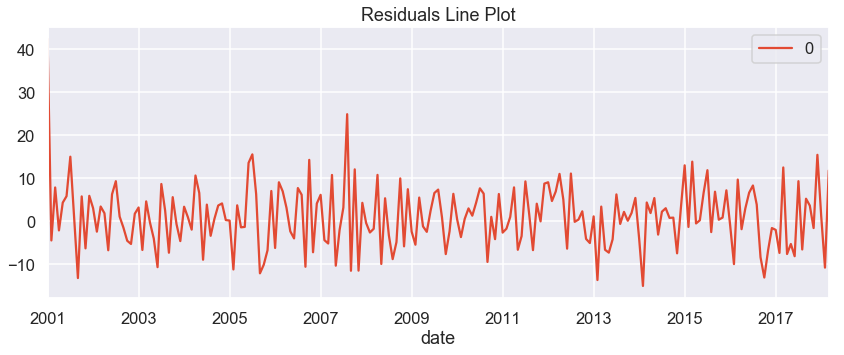

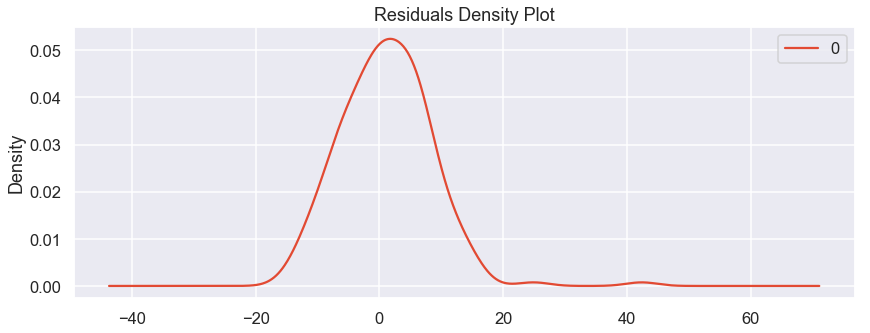

                0
count  207.000000
mean     1.086978
std      7.385014
min    -14.989805
25%     -4.056800
50%      0.977447
75%      5.893020
max     42.388663


In [111]:
# line plot of residuals
residuals = pd.DataFrame(model_1stgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())


The residuals over time don't display any obvious seasonality and appear to be white noise.
The distribution seems to be close to a gaussian, even if it is not centered on zero but not so far from it, as we can observe from the mean being around 1.
We will double check the stationarity of the residuals once again with the Dickey-Fuller test.

In [112]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.364970
p-value                          0.000342
#Lags Used                      12.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


Finally let us calculate the RMSE of the mosel compared to the train set.

In [113]:
print(f'{Fore.GREEN}The RMSE for the best ARMA model after first grid search,\
on the train, is in TWh:{round(find_rmse(model_1stgrd),2)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid search,on the train, is in TWh:7.45


This is a good result considering that the RMSE for the naive model was around 12 TWh.
But we are fitting the model on the whole train and making predictions on it. To get more authentic results that can actually tell us more of what would happen with unseen data, let us do some cross validation.
As we have seen about we have created already some splits of the train set, into train and validation. Now we are going to use those splits.
### Cross Validation

In [114]:
train.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01'],
              dtype='datetime64[ns]', name='date', length=207, freq=None)

In [115]:
train_with_ind = train.reset_index()

In [116]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    #fitting on the train from the train-validation split
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(8, 1, 2)).fit()
    #predicting on the validation part of the sample
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    #comparing validation and predictions on validation
    print(np.sqrt(mean_squared_error(true, preds)))

12.708135814845262
11.213173508277036
16.513312146403646
11.213621195887724
13.992694000579876


In [117]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in TWh: 13.13


These values of RMSE are higher because this time I am doing a cross validation and I am not fitting on the validation set but only on the train (for every split).

Let us see if we can improve this even further by doing one more ARIMA search.

## Second grid search for ARIMA

Since the model with the highest value for p in its range turned out to be the best, we decided to do this second search trying even higher values for p, and increasing the values for d and q, adding also a term 4 to the search.

In [118]:
# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1, 2, 4]
q_values = [1, 2, 4]
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 1, 4) AIC=1436.469
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
ARIMA(8, 2, 4) AIC=1510.460
ARIMA(8, 4, 1) AIC=1663.977
ARIMA(8, 4, 2) AIC=1657.738
ARIMA(8, 4, 4) AIC=1610.641
ARIMA(10, 1, 1) AIC=1430.631
ARIMA(10, 1, 2) AIC=1382.235
ARIMA(10, 1, 4) AIC=1379.521
ARIMA(10, 2, 1) AIC=1428.363
ARIMA(10, 2, 2) AIC=1405.720
ARIMA(10, 2, 4) AIC=1382.432
ARIMA(10, 4, 1) AIC=1666.712
ARIMA(10, 4, 2) AIC=1555.090
ARIMA(10, 4, 4) AIC=1612.697
ARIMA(12, 1, 1) AIC=1355.815
ARIMA(12, 1, 2) AIC=1357.197
ARIMA(12, 1, 4) AIC=1351.353
ARIMA(12, 2, 1) AIC=1363.006
ARIMA(12, 2, 2) AIC=1365.921
ARIMA(12, 2, 4) AIC=1357.246
ARIMA(12, 4, 1) AIC=1494.013
ARIMA(12, 4, 2) AIC=1426.679
ARIMA(12, 4, 4) AIC=1413.385
ARIMA(20, 1, 1) AIC=1359.881
ARIMA(20, 1, 2) AIC=1361.479
ARIMA(20, 1, 4) AIC=1362.721
ARIMA(20, 2, 1) AIC=1364.163
ARIMA(20, 2, 2) AIC=1361.240
ARIMA(20, 2, 4) AIC=1363.167
ARIMA(20, 4, 1) AIC=1467.434
ARIMA(20, 4, 2) AIC=145

### Best model from second search

Taking the best model from this search

In [119]:
model_2ndgrd = ARIMA(train, order=(12, 1, 4)).fit()
model_2ndgrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                ARIMA(12, 1, 4)   Log Likelihood                -658.676
Date:                Mon, 20 Mar 2023   AIC                           1351.353
Time:                        10:19:22   BIC                           1407.927
Sample:                    01-01-2001   HQIC                          1374.233
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3027      0.207     -1.464      0.143      -0.708       0.103
ar.L2         -0.2799      0.142     -1.974      0.048      -0.558      -0.002
ar.L3         -0.4302      0.149     -2.878      0.004      -0.723      -0.137
ar.L4         -0.4329      0.197     -2.201      0.028      -0.818      -0.047
ar.L5         -0.2470      0.132     -1.872      0.061      -0.506       0.012
ar.L6         -0.4220      0.138     -3.049      0.002      -0.693      -0.151
ar.L7         -0.3404      0.160     -2.125      0.034      -0.654      -0.026
ar.L8         -0.3233      0.145     -2.237      0.025      -0.607      -0.040
ar.L9         -0.4178      0.141     -2.959      0.003      -0.695      -0.141
ar.L10        -0.3538      0.171     -2.067      0.039      -0.689      -0.018
ar.L11        -0.1891      0.137     -1.378      0.168      -0.458       0.080
ar.L12         0.3968      0.127      3.130      0.002       0.148       0.645
ma.L1          0.1038      0.205      0.507      0.612      -0.297       0.505
ma.L2          0.0177      0.134      0.132      0.895      -0.245       0.280
ma.L3          0.3335      0.119      2.796      0.005       0.100       0.567
ma.L4          0.2343      0.175      1.339      0.181      -0.109       0.577
sigma2        32.5947      3.235     10.075      0.000      26.254      38.936
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                12.67
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.24
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

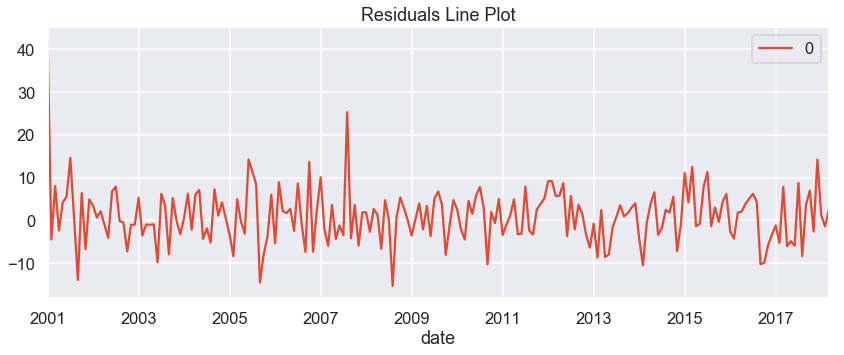

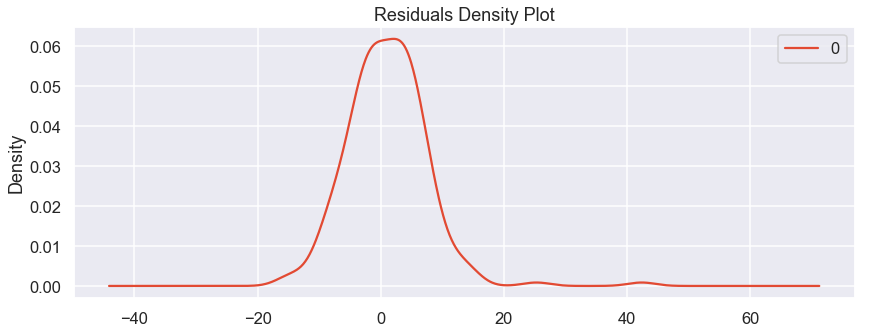

                0
count  207.000000
mean     1.032578
std      6.535763
min    -15.282077
25%     -3.255835
50%      0.972571
75%      4.910723
max     42.388663


In [120]:
# line plot of residuals
residuals = pd.DataFrame(model_2ndgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

Once again the residulas seem stationary, and with a distribution similar to a gaussian.
Double checking again with the DF test.

In [121]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -1.683046e+01
p-value                        1.159088e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


In [122]:
print(f'{Fore.BLUE}The RMSE for the best ARMA model after first grid, on the train, is in TWh: {round(find_rmse(model_2ndgrd),2)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train, is in TWh: 6.6


This is an even lower RMSE compared to the previous model (from the first grid search).
Let us do once again cross validation with this model.

### Cross Validation:

In [123]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(12, 1, 4)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

13.681955414614956
9.83766952796604
15.77849205654935
16.515790573627143
13.716203910073446


In [124]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in TWh is: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in TWh is: 13.91


These results for RMSE are not terrible, but they are still higher than the RMSE of the simple naive model.
The AIC also, is lower than what we have seen previously, but still leaves a lot to be desired.

# Including Seasonality: SARIMAX

There is something else happening in our time series that we haven't taken into account yet, and definitely plays a major role: seasonality.
<br>The ARIMA models were able to predict pretty well on our data, but part of the problem in their performance might be coming from the fact that we are supposed to model on a series that is stationary, while our series has both a trend and a seasonality.
The ARIMA integrated models take care of the trend, but they do not include seasonality.
<br>So let us try now using a SARIMAX model which includes also 4 more terms, to account for seasonality.
<br>Instead of wasting time with random trials of all the different parameters, we will start directly with a grid search to try all the different combinations of parameters for our models, and we will evalauate more in detail the best model from this search.

## First Grid Search SARIMAX

In [125]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


It is very time consuming to run the grid search, so we pickled the GridSearchCV results in a DataFrame.
We show below all the code that was used for demonastrative purposes, but we comment it out and keep only the results of the search.

In [126]:
"""CODE that was used to conduct the SARIMAX grid search:

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

"CODE that was used to conduct the SARIMAX grid search:\n\nans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue"

In [127]:
"""CODE used to extract the model with lowest AIC

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

"CODE used to extract the model with lowest AIC\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]"

In [128]:
# CODE used to pickle df of results
# ans_df.to_pickle("./SARgrid1.pkl")

Reading the DataFrame with the results from the pickled file:

In [129]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  

Sorting the DataFrame from the lowest AIC value:

In [130]:
res_grid_df.sort_values(by='aic').head(10)

,pdq,pdqs,aic
838,"(8, 2, 2)","(8, 4, 1, 12)",390.300560
568,"(6, 1, 1)","(8, 4, 1, 12)",401.144101
749,"(8, 1, 1)","(8, 4, 2, 12)",404.020123
598,"(6, 1, 2)","(8, 4, 1, 12)",406.228081
779,"(8, 1, 2)","(8, 4, 2, 12)",407.293806
388,"(4, 1, 1)","(8, 4, 1, 12)",412.478274
569,"(6, 1, 1)","(8, 4, 2, 12)",412.843780
599,"(6, 1, 2)","(8, 4, 2, 12)",415.171388
839,"(8, 2, 2)","(8, 4, 2, 12)",416.268315
628,"(6, 2, 1)","(8, 4, 1, 12)",424.192994


## Best SARIMAX model after first grid search

We can already see a great improvement in the AIC values.
Now let us run the best model and see the results.

In [131]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL1 =SARIMAX(train, 
                        order=(8, 2, 2), 
                        seasonal_order=(8, 4, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model and print results
output1 = SARIMA_MODEL1.fit()

In [132]:
output1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Generation (TWh)   No. Observations:                  207
Model:             SARIMAX(8, 2, 2)x(8, 4, [1], 12)   Log Likelihood                -175.150
Date:                              Mon, 20 Mar 2023   AIC                            390.301
Time:                                      10:22:48   BIC                            429.706
Sample:                                  01-01-2001   HQIC                           405.454
                                       - 03-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5381      0.991     -0.543      0.587      -2.480       1.404
ar.L2         -0.0563      0.567     -0.099      0.921      -1.167       1.054
ar.L3         -0.2800      0.383     -0.732      0.464      -1.030       0.470
ar.L4         -0.1306      0.456     -0.287      0.774      -1.024       0.763
ar.L5          0.3590      0.306      1.174      0.241      -0.241       0.959
ar.L6         -0.0661      0.368     -0.180      0.857      -0.787       0.655
ar.L7         -0.4037      0.228     -1.772      0.076      -0.850       0.043
ar.L8          0.0868      0.466      0.186      0.852      -0.827       1.000
ma.L1         -0.8643      0.889     -0.972      0.331      -2.607       0.879
ma.L2         -0.4374      1.056     -0.414      0.679      -2.508       1.633
ar.S.L12      -2.2225      0.228     -9.764      0.000      -2.669      -1.776
ar.S.L24      -2.8372      0.472     -6.009      0.000      -3.763      -1.912
ar.S.L36      -3.2945      0.573     -5.749      0.000      -4.418      -2.171
ar.S.L48      -3.2810      0.626     -5.239      0.000      -4.509      -2.054
ar.S.L60      -2.7371      0.583     -4.697      0.000      -3.879      -1.595
ar.S.L72      -1.8037      0.439     -4.107      0.000      -2.664      -0.943
ar.S.L84      -0.9144      0.252     -3.627      0.000      -1.408      -0.420
ar.S.L96      -0.3456      0.093     -3.721      0.000      -0.528      -0.164
ma.S.L12       1.9199      1.379      1.392      0.164      -0.783       4.623
sigma2         0.6440      1.048      0.615      0.539      -1.410       2.698
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.65   Prob(JB):                         0.87
Heteroskedasticity (H):               0.95   Skew:                             0.02
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature.
We can notice that the seasonal components (the ones with the capital S) have a higher feature weight compared to the non seasonal terms, which in fact all have 𝑃>|𝑧| while all the seasonal components have a p value of zero.

Let us move on to calculating the RMSE for this model.

In [133]:
y_hat_train1 = output1.predict(typ='levels')
RMSE_train1=round(np.sqrt(mean_squared_error(train, y_hat_train1)),2)
print(f'{Fore.RED}RMSE SARIMA on the train, after first grid search in TWh: {RMSE_train1}{Style.RESET_ALL}')

RMSE SARIMA on the train, after first grid search in TWh: 20.61


Next, let us check once again the residuals of the model:

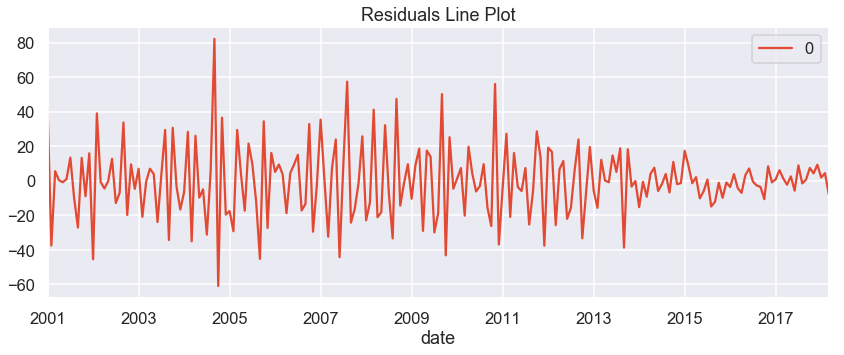

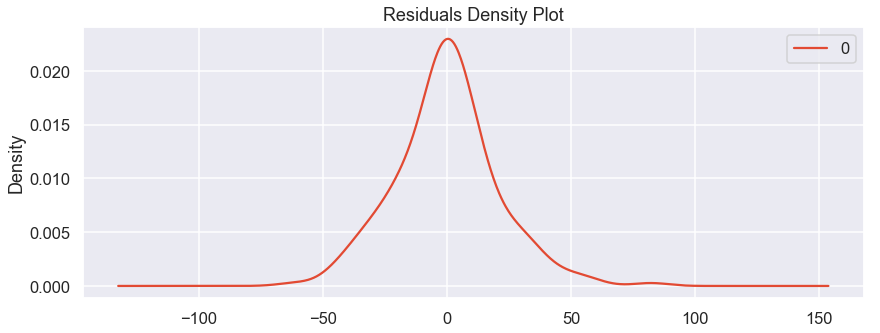

                0
count  207.000000
mean    -0.168100
std     20.663356
min    -60.895327
25%    -12.142413
50%     -0.564844
75%      9.553174
max     82.190351


In [134]:
# line plot of residuals
residuals = pd.DataFrame(output1.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

Once again the residulas seem stationary, and with a gaussian distribution.
Double checking again with the DF test.

In [135]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.041873e+00
p-value                        1.339978e-07
#Lags Used                     9.000000e+00
Number of Observations Used    1.970000e+02
Critical Value (1%)           -3.463987e+00
Critical Value (5%)           -2.876326e+00
Critical Value (10%)          -2.574652e+00
dtype: float64


Let us do once again cross validation to check a more realistic performance of this model.

#### Cross Validation

In [136]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 2, 2), 
                    seasonal_order=(8, 4, 1, 12), 
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

459.47352067573576
1439.5228973231533
644.4040220080257
288.62061973835614
182.37465170087768


In [137]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in TWh: 602.88


We actually calculated the RMSE with cross validation for more than this one model, but for reasons of brevity and running time of the notebook, we are omitting those calculations, as they led to a very similar result.

This result is much worse than the previous ones we got, definitely worth doing a second grid search with different parameters to find a better model.
And once again since previously higher number of terms perfmormed better, we will try with higher values for p.

## Second Grid Search SARIMAX:

In [138]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [8, 12]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


Once again it would be too long to run this code again so we pickled the model in a DF, showing the code here below. 

In [139]:
"""CODE used for the second grid search

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

"CODE used for the second grid search\n\nans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue"

In [140]:
"""Results of the second grid search

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

"Results of the second grid search\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]"

In [141]:
#Pickling the results of the second grid search
#ans_df.to_pickle("./SARgs.pkl")

In [142]:
results_df = pd.read_pickle("./SARgs.pkl")  

DataFrame with grid results sorted by lowest AIC:

In [143]:
results_df.sort_values(by='aic').head(10)

,pdq,pdqs,aic
14,"(8, 1, 2)","(12, 2, 1, 12)",173.506577
7,"(8, 1, 1)","(12, 2, 2, 12)",180.441275
6,"(8, 1, 1)","(12, 2, 1, 12)",181.372341
30,"(8, 2, 2)","(12, 2, 1, 12)",184.947537
23,"(8, 2, 1)","(12, 2, 2, 12)",185.479998
22,"(8, 2, 1)","(12, 2, 1, 12)",185.748173
15,"(8, 1, 2)","(12, 2, 2, 12)",188.303187
31,"(8, 2, 2)","(12, 2, 2, 12)",199.936131
28,"(8, 2, 2)","(12, 1, 1, 12)",225.506853
29,"(8, 2, 2)","(12, 1, 2, 12)",234.166871


As we can see the AIC values are all lower than the AICs from the first grid search.
<br>Now we will proceed to generate and test the best model.

## Best SARIMAX model 2nd grid search

In [144]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL2 = SARIMAX(train, 
                        order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                        enforce_stationarity=True, 
                        enforce_invertibility=True)

# Fit the model and print results
output2 = SARIMA_MODEL2.fit()

output2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.1730,0.167,-1.034,0.301,-0.501,0.155
ar.L2,0.6159,0.128,4.817,0.000,0.365,0.866
ar.L3,0.1683,0.106,1.590,0.112,-0.039,0.376
ar.L4,0.1002,0.110,0.912,0.362,-0.115,0.316
ar.L5,-0.0547,0.112,-0.488,0.626,-0.274,0.165
ar.L6,-0.0524,0.103,-0.511,0.610,-0.254,0.149
ar.L7,-0.1145,0.112,-1.026,0.305,-0.333,0.104
ar.L8,0.0731,0.107,0.685,0.493,-0.136,0.282
ma.L1,-0.1458,0.246,-0.592,0.554,-0.628,0.337
ma.L2,-0.8297,0.180,-4.607,0.000,-1.183,-0.477


In [145]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=round(np.sqrt(mean_squared_error(train, y_hat_train2)),2)
print(f'{Fore.BLUE}RMSE of SARIMA model after second grid search : TWh {RMSE_train2}{Style.RESET_ALL}')

RMSE of SARIMA model after second grid search : TWh 7.53


Next, let us check once again the residuals of the model:

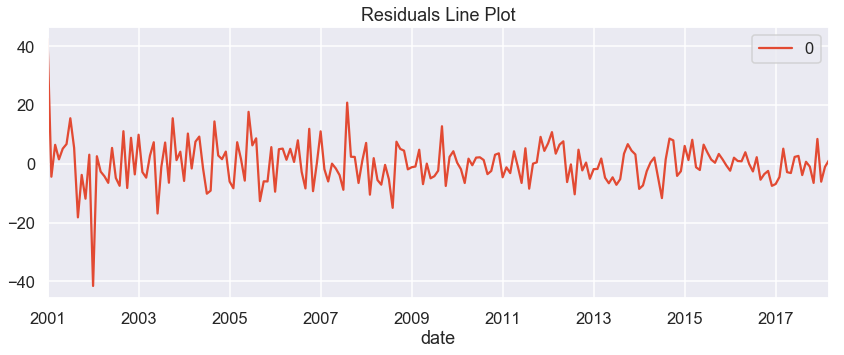

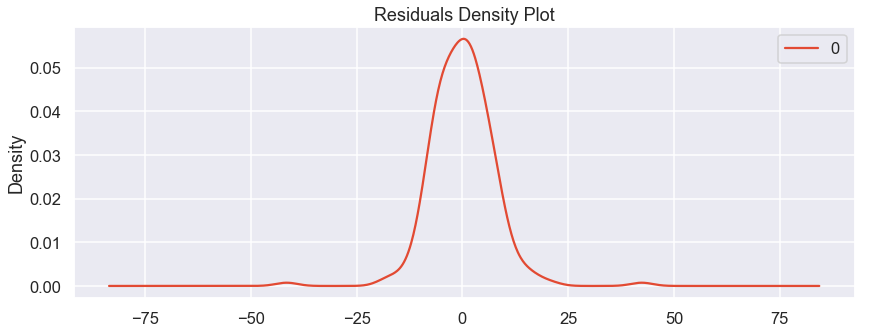

                0
count  207.000000
mean     0.017361
std      7.551832
min    -41.517297
25%     -4.667058
50%      0.023771
75%      4.285245
max     42.388663


In [146]:
# line plot of residuals
residuals = pd.DataFrame(output2.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

All good, the gaussian is actually even more centered around zero than before.
Let's check stationarity of the residuals.

In [147]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -1.688852e+01
p-value                        1.049503e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


And now let us do one final Cross Validation to be able to compare the models.

In [148]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                     enforce_stationarity=True,
                     enforce_invertibility=True).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

47.32479818047728
37.30616363413895
9.566750980222713
17.344266346089785
10.804881953711952


In [149]:
mean=round(np.mean(cv),2)
print(f'{Fore.GREEN}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in TWh: 24.47


Much better result this time!
<br>We actually calculated the RMSE with cross validation for more than this one model, but for reasons of brevity and running time of the notebook, we are omitting those calculations, as they led to a very similar result.
<br>Now let us do a quick recap of the results thus far.

### In terms of the RMSE:
The ARIMA model gave a better result, since it has a lower RMSE of 14.24 TWh after cross validation, while the RMSE of the SARIMAX model after cross validation is 24.47 TWh.
### In terms of AIC:
The ARIMA model (before the SARIMAX searches) had an AIC of 1355.815.
<br>The model from the second SARIMAX grid search has an AIC of only 173.

### Which metric:
There is a substantial difference between these two metrics.

We want the AIC to be low because it gives us a sense of the overall goodness of the model and penalizes models that are too complex, so it should prevent overfitting.
<br>We also want the RMSE to be low because that is what ultimately tells us how well the model is performing, compared to the data.

We decided to pick the model with the lowest AIC as our best model, since it prevents us from the risk of overfitting, and it is a more well rounded metric that evaluates the goodness of model overall, not as dependent on the data as RMSE is.

Now that we have selected the SARIMAX(8, 1, 2)(12, 2, 1, 12) we will proceed to predict with this model on the test set, and we will use again the RMSE as a metric to get a sense of how well this model is predicting on the data.

# Predicting on the Test <a id='Pred'></a>

Generating prediction on the test set with our last model.
<br>It is worth noting that the model was fitted only on the train and the test set was not touched and used for any evaluation up until this point, so we should have been able to avoid the risk of data leakage.
<br>Predictions and predictions' confidence interval:

In [150]:
y_hat_test = output2.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
y_hat_train = output2.get_prediction(start=pd.to_datetime('2001-01-01'), \
                        end=pd.to_datetime('2018-03-01'), dynamic=False, full_results=True)
pred_conf=y_hat_test.conf_int()

To be able to visualize better the predictions we cut the first part of the time series before 2010.

In [151]:
nat_cut=nat['2010-01-01':]

Plotting the predictions, with prediction confidence interval in the green shaded area:

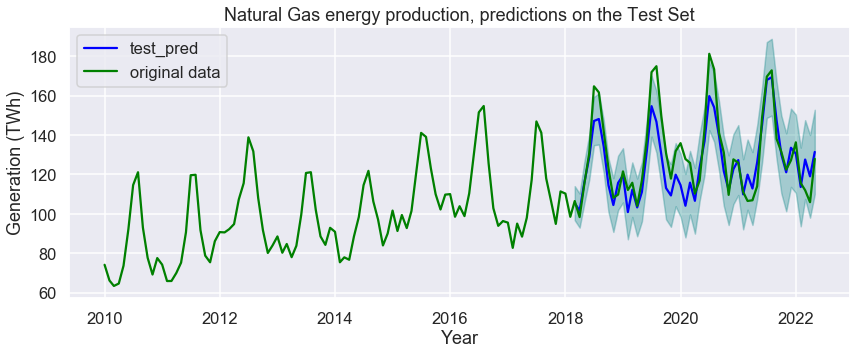

In [152]:
fig, ax = plt.subplots()
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.plot(y_hat_test.predicted_mean, label='test_pred', color='b')
ax.plot(nat_cut, label='original data', color='g')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

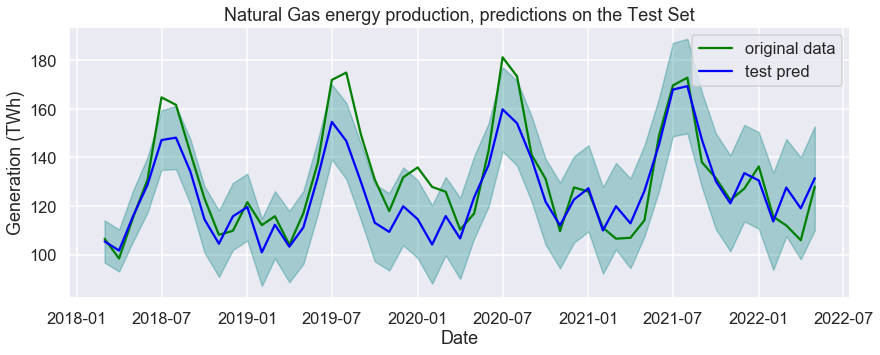

In [153]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='original data', color='g')
ax.plot(y_hat_test.predicted_mean, label='test pred', color='b')
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Generation (TWh)")
plt.legend();

Calculating the RMSE on the test:

In [154]:
rmse=round(np.sqrt(mean_squared_error(test, y_hat_test.predicted_mean)),3)
print(f'{Fore.BLUE}RMSE of our model on the test set in TWh: {rmse}{Style.RESET_ALL}')

RMSE of our model on the test set in TWh: 10.901


This is a great result and we were able to achieve a Root Mean Squared Error lower than the Baseline Naive Model!
<br>The choice of the best AIC ended up being a wise one since we don't see overfitting in our model, as the performance didn't decrease once we used the model on the unseen test set.
<br>Just for the sake of information, we tried to use the ARIMA best model on the test and it showed us that there was definitely overfitting in that case, since it returned a worse RMSE of 20.22 TWh (see and uncomment code below).

In [155]:
#mode = ARIMA(train, order=(8,1,2)).fit()
#y_hat_test = mode.get_prediction(start=pd.to_datetime('2018-03-01'),\
#                end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
#np.sqrt(mean_squared_error(test, y_hat_test.predicted_mean))

We can also extract the values point by point of our prediction from the following table:

In [156]:
pred_conf.head()

,lower Generation (TWh),upper Generation (TWh)
2018-03-01,96.795133,114.087176
2018-04-01,93.032882,110.320843
2018-05-01,105.377250,126.312867
2018-06-01,117.336819,140.169093
2018-07-01,134.869443,159.446187


To get a sense of how the model is doing predicting the whole series:

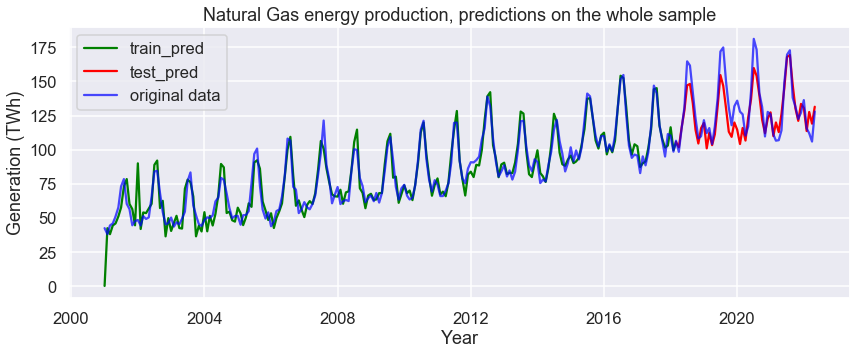

In [157]:
fig, ax = plt.subplots()
#ax.fill_between(pred_conf.index,
#                pred_conf.iloc[:, 0],
#                pred_conf.iloc[:, 1], color='g', alpha=0.3)
ax.plot(y_hat_train.predicted_mean, label='train_pred', color='g')
plt.title('Natural Gas energy production, predictions on the whole sample')
ax.plot(y_hat_test.predicted_mean, label='test_pred', color='r')
ax.plot(nat, label='original data', color='b', alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend();

## Forecasting <a id='Fore'></a>

Now we will use the same model, but fitting it on the whole dataset we have available, to make the best possible predictions, for the next 3 years.

In [158]:
#this time fit the chosen model on the whole set!
final = SARIMAX(nat,
                  order=(8, 1, 2), 
                  seasonal_order=(12, 2, 1, 12), 
                  enforce_stationarity=True,
                  enforce_invertibility=True).fit()

We need to set the number of steps. Every step is a month, if we want to predict 3 years in the future that is 36 steps.

In [159]:
forecast = final.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = forecast.conf_int()

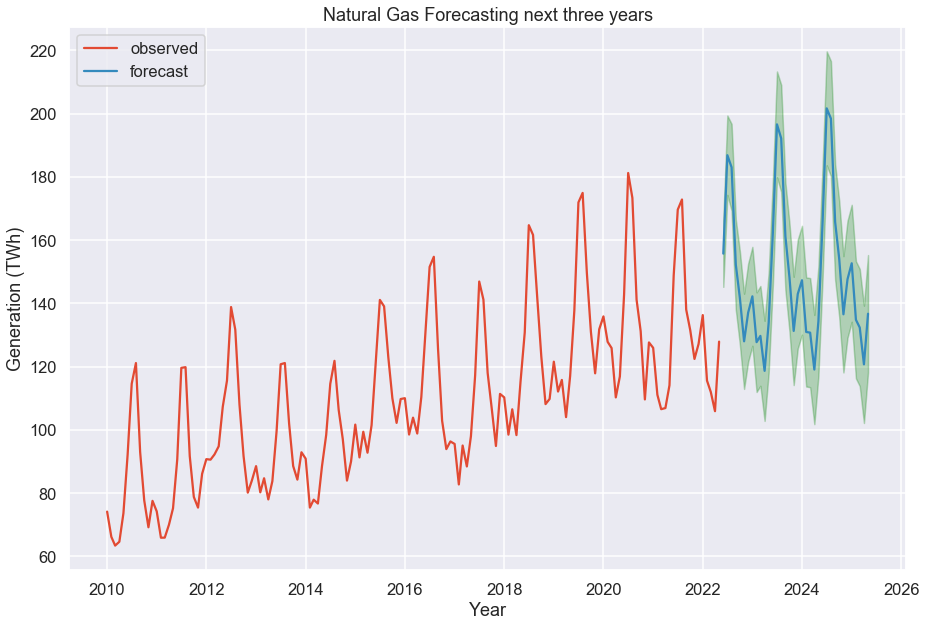

In [160]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(nat_cut, label='observed')
ax.plot(forecast.predicted_mean, label='forecast')
ax.set_title('Natural Gas Forecasting next three years')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

Zooming in on the predictions:

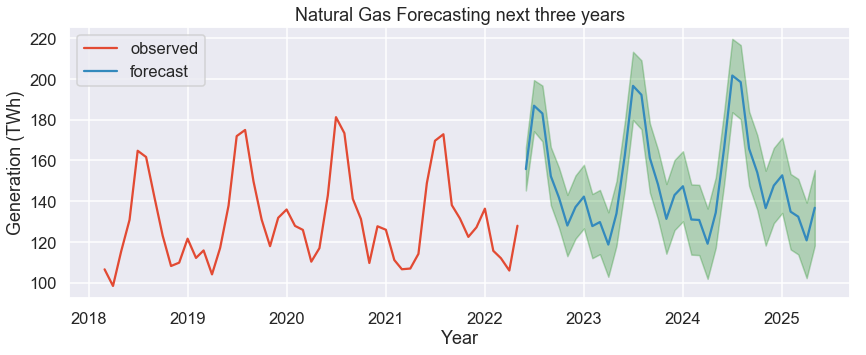

In [161]:
fig, ax = plt.subplots()
ax.plot(test, label='observed')
ax.plot(forecast.predicted_mean, label='forecast')
ax.set_title('Natural Gas Forecasting next three years')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

We see a steady growth in the production of natural gas, with a seasonality very similar to the one we have seen so far, and with a general growing positive trend.
<br>We can notice that the confidence intervals generated by our model grow larger as we move further out into the future. This is expected because as we forecast further out into the future, it is natural for us to become less confident in our values.
<br>We can look at the summary table below to get a few more details:

In [162]:
print(forecast.summary_frame())

Generation (TWh)        mean   mean_se  mean_ci_lower  mean_ci_upper
2022-06-01        155.756269  5.361166     145.248578     166.263960
2022-07-01        186.873696  6.403075     174.323900     199.423492
2022-08-01        183.055237  6.990843     169.353437     196.757037
2022-09-01        152.286693  7.262868     138.051734     166.521652
2022-10-01        141.738122  7.515580     127.007856     156.468387
2022-11-01        128.030033  7.681373     112.974817     143.085248
2022-12-01        137.100233  7.912892     121.591251     152.609215
2023-01-01        142.245989  7.977247     126.610872     157.881106
2023-02-01        127.760662  8.035470     112.011431     143.509894
2023-03-01        129.738335  8.050874     113.958912     145.517759
2023-04-01        118.684768  8.076702     102.854723     134.514813
2023-05-01        133.942298  8.082203     118.101472     149.783124
2023-06-01        162.659768  8.424353     146.148339     179.171197
2023-07-01        196.626565  8.53

In [163]:
pred_conf.head()

,lower Generation (TWh),upper Generation (TWh)
2022-06-01,145.248578,166.263960
2022-07-01,174.323900,199.423492
2022-08-01,169.353437,196.757037
2022-09-01,138.051734,166.521652
2022-10-01,127.007856,156.468387


To get a more concrete sense of what type of growth we are looking let us take the last full year that we have in our model, and the last full year of the prediction, and compare their highest values.

In [164]:
nat_max=nat['2021'].max()
nat_max

172.859149

In [165]:
fore=forecast.summary_frame()
fore_max=fore['2024']['mean'].max()
fore_max

201.68677883807382

With these two values we can calculate the Year over Year growth in percentage between 2021 and 2024:

In [166]:
YoY=(fore_max/nat_max)-1
YoY

0.16676947679566445

Which represent a year-over-year growth of 16.7% between 2021 and 2024 with a relative error of 4%.

The error is calculated are reative error, which would be the sum of the two quantities' relative errors, but since the value of energy in 2021 doesn't have an error, it is simply the relative error of the value in 2024.

#### One more fun thing

To see the full result of what we obtained, we can add our forecast to the data we had originially, and see once more a seasonal decomposition, to see what the trend and seasonality look like, once we include our forecast.

In [167]:
total=pd.concat([nat,fore['mean']])

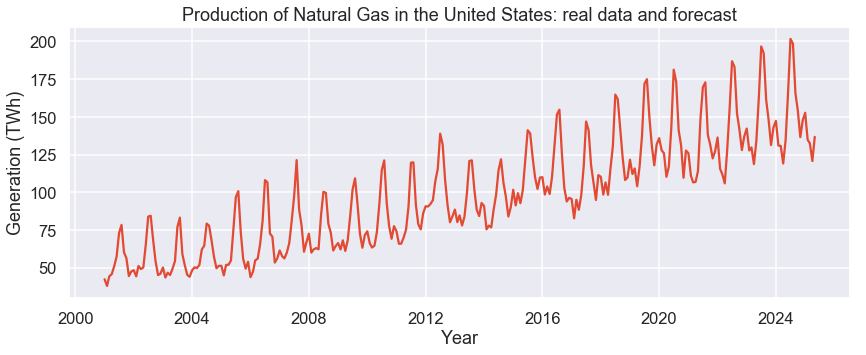

In [168]:
plt.title('Production of Natural Gas in the United States: real data and forecast')
plt.plot(total)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)");

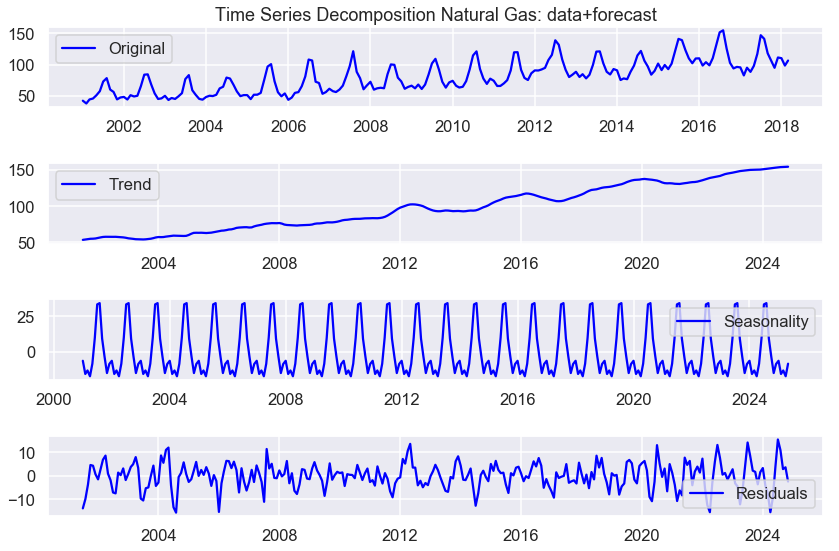

In [169]:
decomposition=seasonal_decompose(total)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas: data+forecast')
plt.plot(train, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

We see confirmed by the seasonal decomposition the general growing trend and the yearly seasonality.

# Study of seasonality and states:<a id='SSS'></a>

One more thing we can learn from our model is about the seasonality of our time series, so we go back to the decomposition we had done before, to extract the seasonality, clean of the trend and residual.

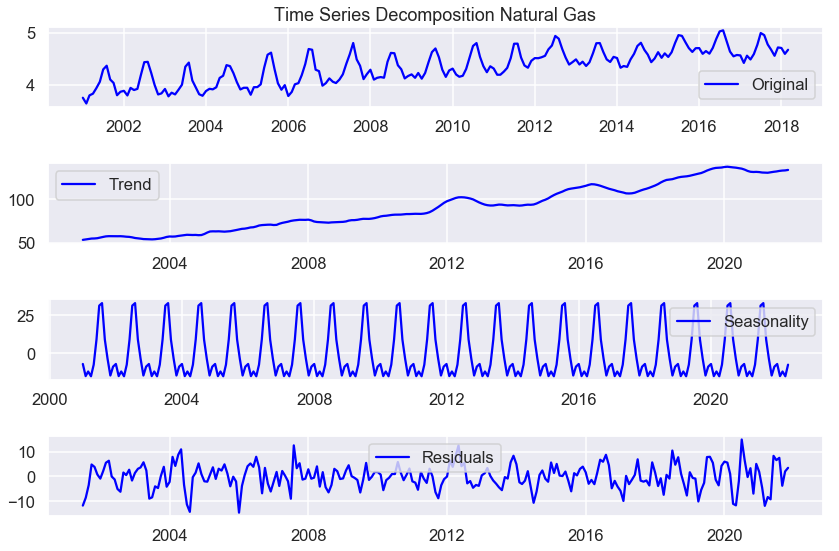

In [170]:
decomposition = seasonal_decompose(nat)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

Isolating one year to see the trend better.

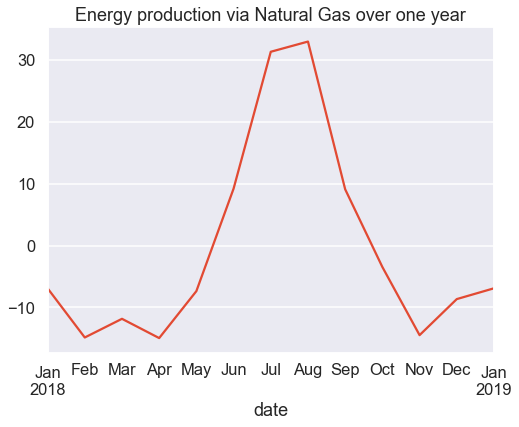

In [171]:
plt.figure(figsize=(8,6))
year=seasonal['2018-01-01':'2019-01-01']
plt.title('Energy production via Natural Gas over one year')
plt.xlabel("Date")
year.plot();

We can see a considerable spike in energy production over the summer months, we will look into this more in a moment.
Next we are going to change scale from the original DataFrame, taking only "Totaly Electric Power Industry" and only "Natural Gas".

In [172]:
df["Generation (TWh)"]=df["GENERATION (Megawatthours)"]/1000000
df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
tot=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
natgas=tot.loc[tot['ENERGY SOURCE']=='Natural Gas']

Next we are going to look at the production of natural gas divided by State, to see which state produces the most of it.

In [173]:
nat_states=natgas.groupby(by=["STATE"]).sum()
nat_states.drop('US-TOTAL', axis=0, inplace=True)
nat_states=nat_states.sort_values(by="Generation (TWh)", ascending=False)

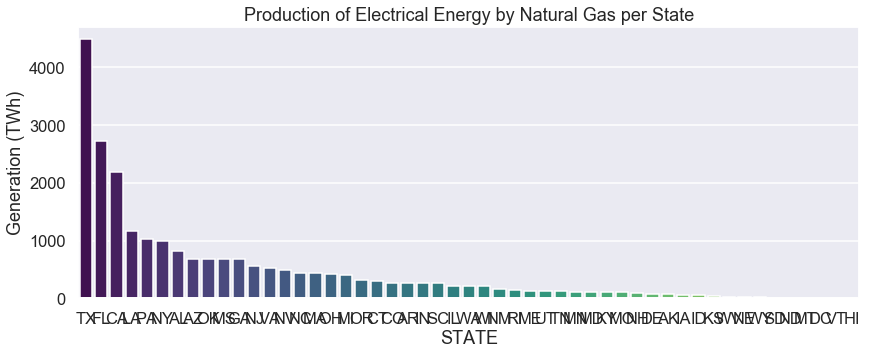

In [174]:
plt.title('Production of Electrical Energy by Natural Gas per State')
sns.barplot(x=nat_states.index, y=nat_states["Generation (TWh)"], palette='viridis');

Focusing on the top 20 producers:

In [175]:
top_20=nat_states.sort_values(by="Generation (TWh)", ascending=False).head(20)

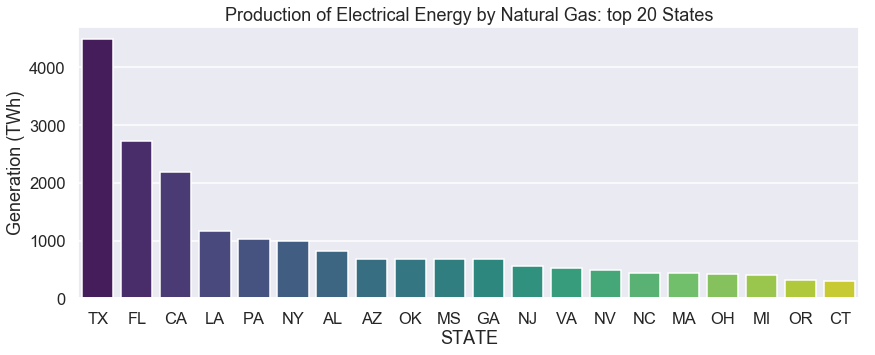

In [176]:
plt.title('Production of Electrical Energy by Natural Gas: top 20 States')
sns.barplot(x=top_20.index, y=top_20["Generation (TWh)"], palette='viridis');

In [177]:
top_int=top_20["Generation (TWh)"].astype(int)

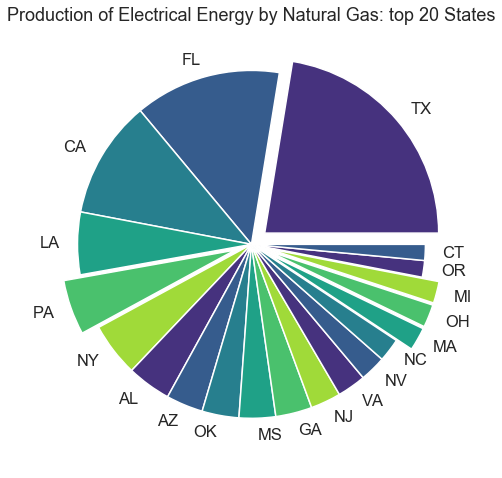

In [178]:
plt.figure(figsize=(8,8))
explode = (0.1, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0,0)
colors = sns.color_palette('viridis')
plt.title('Production of Electrical Energy by Natural Gas: top 20 States')
plt.pie(top_int,labels=top_20.index, colors=colors, explode=explode,);

We can see that Texas has the lead in terms of production of Electrical Power via natural gas, followed by Florida and California.
But let us take a look at one year of production in Texas:

In [179]:
#Isolating Texas
TX=natgas.loc[natgas['STATE']=='TX']
#Creatng a series with the Generation column
TXs=TX["Generation (TWh)"]

In [180]:
#Doing seasonal decomposition
decomposition = seasonal_decompose(TXs)
seasonal_TX = decomposition.seasonal
#selecting one year in the season
yearTX=seasonal_TX['2018-01-01':'2019-01-01']

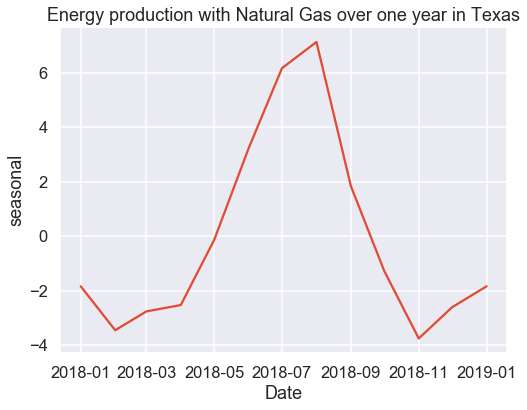

In [181]:
plt.figure(figsize=(8,6))
plt.title('Energy production with Natural Gas over one year in Texas')
sns.lineplot(x=yearTX.index,y=yearTX)
plt.xlabel("Date");

We see again the very high spike in production in the summer months.
<br>We can imagine that this is due to the hot climate in Texas during those months, that requires most houses and buildings to run constantly their air conditioner units.
<br>We can expect to find a similar behaviour in the other highest producing states since they all happen to be in the South, where the heat is more severe in the summer.
<br>This can be complicated and create shortages which can lead to several serious problems.
<br>We can look into other states, not in the South, that don't suffer as much from this type of seasonality.
<br>We will take a few states in the North of the United States and study their trend over a year, to see what that looks like in states that have a more mild climate.
<br>Starting from the top producing states, we selected: Pennsylvania, Massachusetts, Ohio and Michigan.

In [182]:
#Isolating Pennsylvania, Massachusetts, Ohio, Michigan
PA=natgas.loc[natgas['STATE']=='PA']
MA=natgas.loc[natgas['STATE']=='MA']
OH=natgas.loc[natgas['STATE']=='OH']
MI=natgas.loc[natgas['STATE']=='MI']

Creating Series to do seasonal decomposition

In [183]:
PAs=PA['Generation (TWh)']
MAs=MA['Generation (TWh)']
OHs=OH['Generation (TWh)']
MIs=MI['Generation (TWh)']

Decomposing:

In [184]:
decomposition = seasonal_decompose(PAs)
seasonal_PA = decomposition.seasonal
yearPA=seasonal_PA['2018-01-01':'2019-01-01']

In [185]:
decomposition = seasonal_decompose(MAs)
seasonal_MA = decomposition.seasonal
yearMA=seasonal_MA['2018-01-01':'2019-01-01']

In [186]:
decomposition = seasonal_decompose(OHs)
seasonal_OH = decomposition.seasonal
yearOH=seasonal_OH['2018-01-01':'2019-01-01']

In [187]:
decomposition = seasonal_decompose(MIs)
seasonal_MI = decomposition.seasonal
yearMI=seasonal_MI['2018-01-01':'2019-01-01']

Plotting the states all together over 1 year:

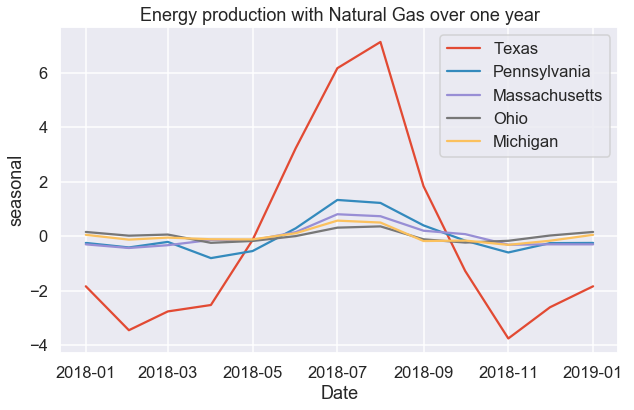

In [188]:
plt.figure(figsize=(10,6))
plt.title('Energy production with Natural Gas over one year')
sns.lineplot(x=yearTX.index,y=yearTX)
sns.lineplot(x=yearPA.index,y=yearPA)
sns.lineplot(x=yearMA.index,y=yearMA)
sns.lineplot(x=yearOH.index,y=yearOH)
sns.lineplot(x=yearMI.index,y=yearMI)
plt.legend(labels=['Texas', 'Pennsylvania', 'Massachusetts', 'Ohio', 'Michigan'])
plt.xlabel("Date");

As we can notice the production of energy is much more stable in these other states, and we can imagine that is due to the much smaller consumption of energy related to air conditioners, since all these states have summers that are much more mild than Texas.
<br>This can be a way to "beat the seasonality", if there is a possibility to invest in more than one state. 
<br>In this way we would be relying on energy in both Texas and another one of these states, that don't necessarily produce an incredible amount of energy, but given their stable production can be a valid backup option in case of shortages from the production in Texas.
<br>Pennsylvania might be the best option in this sense since it was still pretty high in the order of producing states (it was number 5, looking at the graph above) but having a much less pronounced peak during the summer compared to Texas and presumably the other warmer states.

# Results <a id='Resu'></a>

With our analysis we wanted to obtain predictions of the production of natural gas.
<br>We selected as our best model a SARIMA model with parameters (8, 1, 2)(12, 2, 1, 12) and with an AIC of 173.5.
<br>With this model we made predictions on the test set, for a span of 51 months, and obtained predictions with a RMSE of 10.9 TWh.
<br>We also forecasted our data in the future for 3 years, finding a growth of up to 16.7% between 2021 and 2024, with an MSE between 5-9 TWh.
<br>We then studied the seasonality of our time series, identifying a recurring pattern every 12 months, and studying the different trends in a few different states, focusing on differences most likely based on geographical area and climate.

# Limitations <a id='Lim'></a>

Cleaning the data: we had almost no cleaning to do of our data. It was already in the vertical format that we wanted, and there was no missing data. If the data input was actually in the long format of dates we suggest the use of the `pd.melt( )` function to reformat the data before being able to run it through our model.
<br>In case of missing data there are three possibilities for filling in the missing data, with either back fill, forward fill or interpolate.

Grid Search: the grid search would give different results for different data. Also the parameters chosen for the search were based on testing on some models that were not included in this notebook. With a different data sample, other models would turn out to be optimal. Therefore it would be necessary to choose other (p,d,q) values for the search and re-run the searches to find the best parameters for the models as described here. Moreover it is not to take for granted that the different models generated would necessarily perform as well as ours did, since they might not be able to pick up the correct trend and seasonality in a different time series and consequently not be able to predict the data with the same accuracy that we obtained.

Running Time: Note that all of the grid searches on SARIMAX had to be run over night or for an extended period of time due to the amount of calculations needed, which will increase as the parameters chosen for the search increase. Also, the fitting of SARIMA models and the cross validation calculations on their results took a considerable amount of running time. If running time is an issue the performance of the models will definitely decrease, as it would be much harder to find such well performing models just by trial and error of different parameters.

# Recommendations<a id='Rec'></a>

We recommend investing in natural gas, solar energy and wind energy, as those appear to be the most growing sources of energy across the states.
<br>When taking into consideration the unpredictability of weather, solar and wind energy possess much more risk and thus less reliability. Ultimately we suggest focusing on states that have natural gas as a main source for generating electrical power. <br>We recommend Texas as the state that has been producing the most electrical power through natural gas. <br>To smooth out the seasonality present in Texas due to the high temperatures in the summer and thus the higher load on generating electricity, we recommend also investing in another state like Pennsylavania, Massachusetts, Ohio or Michigan where there is more of a stable trend in the production of energy annually through natural gas.

## Next Steps

To improve our model and for a more in depth study we could also:
- Study solar and wind generated energy trends.
- Collect more data for a better detailed analysis, scraping information both farther in the past and records by day instead of by month.
- Deepen our study of trend and seasonality looking into the possible most influential factors.
- Utilize more powerful tools like Prophet or AWS SageMaker’s DEEPAR which were not available to us for this study.